### Balíčky a dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import seaborn as sns
import scipy.stats as stats
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, root_mean_squared_error ,r2_score

In [2]:
# Nahrání datasetu
file_path = "Case_Study_DS_PG 1.csv"
df = pd.read_csv(file_path)

### Pochopení dat

In [3]:
# Základní informace
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300000 entries, 0 to 299999
Data columns (total 17 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Unnamed: 0        300000 non-null  int64  
 1   Campaign_ID       300000 non-null  int64  
 2   Target_Audience   300000 non-null  object 
 3   Campaign_Goal     300000 non-null  object 
 4   Duration          300000 non-null  object 
 5   Channel_Used      300000 non-null  object 
 6   Conversion_Rate   300000 non-null  float64
 7   Acquisition_Cost  300000 non-null  object 
 8   ROI               300000 non-null  float64
 9   Location          300000 non-null  object 
 10  Language          300000 non-null  object 
 11  Clicks            300000 non-null  int64  
 12  Impressions       300000 non-null  int64  
 13  Engagement_Score  300000 non-null  int64  
 14  Customer_Segment  300000 non-null  object 
 15  Date              300000 non-null  object 
 16  Company           30

In [4]:
# Zobrazení prvních 5 řádků
df.head()

,Unnamed: 0,Campaign_ID,Target_Audience,Campaign_Goal,Duration,Channel_Used,Conversion_Rate,Acquisition_Cost,ROI,Location,Language,Clicks,Impressions,Engagement_Score,Customer_Segment,Date,Company
0,0,529013,Men 35-44,Product Launch,15 Days,Instagram,0.15,$500.00,5.790000,Las Vegas,Spanish,500,3000,7,Health,2022-02-25,Aura Align
1,1,275352,Women 45-60,Market Expansion,15 Days,Facebook,0.01,$500.00,7.210000,Los Angeles,French,500,3000,5,Home,2022-05-12,Hearth Harmony
2,2,692322,Men 45-60,Product Launch,15 Days,Instagram,0.08,$500.00,0.430000,Austin,Spanish,500,3000,9,Technology,2022/06/19,Cyber Circuit
3,3,675757,Men 25-34,Increase Sales,15 Days,Pinterest,0.03,$500.00,0.909824,Miami,Spanish,293,1937,1,Health,2022-09-08,Well Wish
4,4,535900,Men 45-60,Market Expansion,15 Days,Pinterest,0.13,$500.00,1.422828,Austin,French,293,1937,1,Home,2022-08-24,Hearth Harmony


In [5]:
# Odstranění znaku dolaru ($) ve sloupci 'Acquisition_Cost' a převedení na datový typ float
df['Acquisition_Cost'] = df['Acquisition_Cost'].replace('[$,]', '', regex=True).astype(float)

# Nahrazení '/' za '-' ve sloupci 'Date' a převedení na formát datetime
df['Date'] = df['Date'].astype(str).str.replace('/', '-')
df['Date'] = pd.to_datetime(df['Date'], format="mixed", errors="coerce")


1. **Úprava sloupce `Acquisition_Cost`**:
   - Odstraňíme znaky `$` a `,`, které mohou být v hodnotách, pomocí regulárního výrazu.
   - Převedeme upravené hodnoty na datový typ `float`, což umožňuje numerické operace.

2. **Úprava sloupce `Date`**:
   - Nejprve nahrazujeme `/` za `-`, aby bylo možné jednodušší zpracování datumu.
   - Poté převádíme hodnoty na formát `datetime`, přičemž využíváme `format="mixed"` (různé formáty data) 
     a `errors="coerce"` (neplatné hodnoty budou převedeny na `NaT` – Not a Time)
   - Neplatná data: 2022-02-29, 2022-02-30, 2022-02-31

In [6]:
# Souhrnné statistiky pro číselné sloupce
numerical_summary = df.describe()

# Zobrazení souhrnné statistiky
display(numerical_summary)

,Unnamed: 0,Campaign_ID,Conversion_Rate,Acquisition_Cost,ROI,Clicks,Impressions,Engagement_Score,Date
count,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,300000.000000,299930
mean,149999.500000,550444.804487,0.080009,7753.750796,3.177691,18153.670370,56034.236387,4.369217,2022-07-02 01:04:53.228419840
min,0.000000,100001.000000,0.010000,500.000000,0.000000,293.000000,1937.000000,1.000000,2022-01-01 00:00:00
25%,74999.750000,325003.500000,0.050000,4121.915000,0.930000,8821.000000,28362.000000,1.000000,2022-04-01 00:00:00
50%,149999.500000,551164.500000,0.080000,7755.900000,2.670000,17230.000000,54098.000000,4.000000,2022-07-02 00:00:00
75%,224999.250000,776284.500000,0.110000,11385.075000,5.330000,26808.000000,80925.250000,7.000000,2022-10-01 00:00:00
max,299999.000000,999998.000000,0.150000,15000.000000,8.000000,40000.000000,120000.000000,10.000000,2022-12-31 00:00:00
std,86602.684716,260252.586037,0.040563,4301.035148,2.461200,11027.023294,32583.136334,3.156492,NaN


In [7]:
# Počet unikátních hodnot pro kategorické sloupce
categorical_summary = df.select_dtypes(include=['object']).nunique()

# Zobrazení výsledeku
display(categorical_summary)


Target_Audience     28
Campaign_Goal        4
Duration             4
Channel_Used         5
Location             5
Language             3
Customer_Segment     5
Company             50
dtype: int64

In [8]:
# Vytvoření slovníku, kde klíče jsou názvy sloupců a hodnoty jsou unikátní hodnoty ve sloupcích
categorical_values_dict = {col: df[col].dropna().unique() for col in df.select_dtypes(include=['object']).columns}

# Maximální počet unikátních hodnot mezi sloupci
max_length = max(len(v) for v in categorical_values_dict.values())

# Kratší sloupce doplníme hodnotami NaN a vytvoříme DataFrame
categorical_values_df_wide = pd.DataFrame({k: pd.Series(v, dtype='object') for k, v in categorical_values_dict.items()})

# Výsledek
display(categorical_values_df_wide)


,Target_Audience,Campaign_Goal,Duration,Channel_Used,Location,Language,Customer_Segment,Company
0,Men 35-44,Product Launch,15 Days,Instagram,Las Vegas,Spanish,Health,Aura Align
1,Women 45-60,Market Expansion,30 Days,Facebook,Los Angeles,French,Home,Hearth Harmony
2,Men 45-60,Increase Sales,45 Days,Pinterest,Austin,English,Technology,Cyber Circuit
3,Men 25-34,Brand Awareness,60 Days,Twitter,Miami,NaN,Food,Well Wish
4,Women 35-44,NaN,NaN,X,New York,NaN,Fashion,Space Spruce
5,All Ages,NaN,NaN,NaN,NaN,NaN,NaN,Feast Flavors
6,Women 25-34,NaN,NaN,NaN,NaN,NaN,NaN,Culinary Quest
7,Men 18-24,NaN,NaN,NaN,NaN,NaN,NaN,Gourmet Grove
8,Women 18-24,NaN,NaN,NaN,NaN,NaN,NaN,Silicon Saga
9,W 18-24,NaN,NaN,NaN,NaN,NaN,NaN,Mode Maven


In [ ]:
# Počet unikátních hodnot pro každý sloupec
unique_values_count = df.nunique()

# Počet chybějících hodnot v každém sloupci
missing_values_count = df.isnull().sum()

# Datové typy jednotlivých sloupců
data_types = df.dtypes

# Vytvoření DataFrame se souhrnnými informacemi o datech
dataset_overview = pd.DataFrame({
    "Počet unikátních hodnot": unique_values_count,
    "Počet chybějících hodnot": missing_values_count,
    "Datový typ": data_types
})

# Výsledek
display(dataset_overview)


,Počet unikátních hodnot,Počet chybějících hodnot,Datový typ
Unnamed: 0,300000,0,int64
Campaign_ID,255092,0,int64
Target_Audience,28,0,object
Campaign_Goal,4,0,object
Duration,4,0,object
Channel_Used,5,0,object
Conversion_Rate,15,0,float64
Acquisition_Cost,250998,0,float64
ROI,1601,0,float64
Location,5,0,object


1. **Klíčové poznatky**

Target_Audience (Cílová skupina)
- Existuje mnoho variant zápisu (např. **"Men 18-24"** vs. **"Men 18 -24"**).
- Jsou zde i nesrozumitelné hodnoty jako **"W o m e n 3 5 - 4 4"**.

Campaign_Goal (Cíl kampaně)
- Pouze **4 unikátní hodnoty**. Kampaně jsou jasně kategorizované podle svého zaměření.

Duration (Délka kampaně)
- Obsahuje pouze standardizované varianty jako **"15 Days"**, **"30 Days"** atd., což naznačuje, že doby trvání jsou dobře definované.

Channel_Used (Použitý kanál)
- Hodnoty odpovídají běžným sociálním sítím (**Instagram, Facebook, Pinterest, Twitter, X**).

Location (Lokalita)
- Pouze **5 unikátních měst** (**Las Vegas, Los Angeles, Austin, Miami, New York**).

Language (Jazyk)
- Obsahuje očekávané hodnoty jako **English, Spanish a French**.

Customer_Segment (Segment zákazníků)
- Obsahuje širokou škálu odvětví (**Health, Home, Technology, Fashion, Food**).

Company (Společnost)
- Velké množství různých názvů firem (**50**)

2. **Další kroky ve zpracování dat**

Vyčištění Target_Audience
- Odstraníme nesprávné mezery a sjednotit formát zápisu.
- změníme **All Ages** na **18-60**
Vytvoření nových sloupců
- Vytvoříme sloupce **Age_Group** a **Gender**

In [10]:
# Oprava všech nesprávných hodnot v Target_Audience
df["Target_Audience"] = df["Target_Audience"].replace({
    "W 18-24": "Women 18-24",
    "W 45-60": "Women 45-60",
    "W 25-34": "Women 25-34",
    " W o m e n   3 5 - 4 4 ": "Women 35-44",
    "W 35-44": "Women 35-44",
    "Men 18 -24": "Men 18-24",
    "Women 35.44": "Women 35-44",
    "Women   18-24": "Women 18-24",
    " W o m e n   2 5 - 3 4 ": "Women 25-34",
    "Men   25-34": "Men 25-34",
    "Men   18-24": "Men 18-24",
    "Women   45-60": "Women 45-60",
    "Men 25 -34": "Men 25-34",
    "Men 45 -60": "Men 45-60",
    "Women   25-34": "Women 25-34",
    "Women 25 -34": "Women 25-34",
    "men 25-34": "Men 25-34",
    "men 18-24": "Men 18-24",
    "men 45-60": "Men 45-60",
    "All Ages" : "18-60"
})

In [11]:
# Četnosti jednotlivých hodnot ve sloupci 'Target_Audience'
target_audience_counts = df["Target_Audience"].value_counts()

# Výsledek
display(target_audience_counts)

Target_Audience
Women 18-24    33593
Men 45-60      33491
Women 25-34    33482
18-60          33447
Men 25-34      33346
Men 35-44      33204
Men 18-24      33181
Women 35-44    33142
Women 45-60    33114
Name: count, dtype: int64

In [12]:
# Rozdělit sloupec 'Target_Audience' na 'Age_Group' a 'Gender'
df["Age_Group"] = df["Target_Audience"].str.extract(r'(\d{2}-\d{2})')
df["Gender"] = df["Target_Audience"].str.extract(r'(Men|Women)')

# Nahradit chybějící hodnoty ve sloupci 'Gender' hodnotou "All" (pro skupinu "18-60")
df["Gender"] = df["Gender"].fillna("All")

Ověření duplicit

In [13]:
# Filtrování všech duplicitních záznamů ve sloupci 'Campaign_ID'
duplicate_rows = df[df.duplicated(subset=["Campaign_ID"], keep=False)]

# Ověření, zda jsou všechny duplicitní řádky identické
identical_duplicates = duplicate_rows.duplicated(keep=False).all()

# Výběr prvních 5 nejčastějších duplicit pro detailní analýzu
sample_campaigns = duplicate_rows["Campaign_ID"].value_counts().index[:5] 

# Detailní pohled na data pro vybrané Campaign_ID
sample_duplicates = df[df["Campaign_ID"].isin(sample_campaigns)]

# Výsledek
display(sample_duplicates)

,Unnamed: 0,Campaign_ID,Target_Audience,Campaign_Goal,Duration,Channel_Used,Conversion_Rate,Acquisition_Cost,ROI,Location,Language,Clicks,Impressions,Engagement_Score,Customer_Segment,Date,Company,Age_Group,Gender
6006,6006,244408,Women 35-44,Product Launch,15 Days,Pinterest,0.04,500.00,0.428993,Las Vegas,French,757,3449,1,Technology,2022-12-13,Tech Titans,35-44,Women
21359,21359,964785,18-60,Increase Sales,15 Days,Instagram,0.03,1247.11,5.720000,Los Angeles,Spanish,3312,11330,7,Home,2022-02-24,Hearth Harmony,18-60,All
25252,25252,244408,18-60,Brand Awareness,15 Days,Instagram,0.04,1508.38,0.050000,Austin,Spanish,3824,12848,7,Home,2022-01-26,Living Luxe,18-60,All
29445,29445,840885,Men 45-60,Brand Awareness,15 Days,Twitter,0.02,1772.41,4.260000,Las Vegas,English,4376,14483,6,Fashion,2022-03-19,Mode Maven,45-60,Men
42465,42465,352139,Men 35-44,Brand Awareness,15 Days,Instagram,0.09,2492.47,2.250000,Miami,Spanish,6091,19561,4,Home,2022-01-02,Hearth Harmony,35-44,Men
51436,51436,352139,Men 25-34,Product Launch,15 Days,Twitter,0.02,2960.09,4.530000,Los Angeles,Spanish,7272,23060,2,Fashion,2022-09-09,Attire Artistry,25-34,Men
53150,53150,964785,Women 45-60,Brand Awareness,15 Days,Pinterest,0.01,3046.16,1.054609,Austin,English,4403,15319,1,Technology,2022-11-05,Giga Geeks,45-60,Women
55126,55126,988079,Women 45-60,Market Expansion,15 Days,Facebook,0.04,3146.66,3.680000,Miami,Spanish,7758,24499,1,Home,2022-03-04,Dwell Delight,45-60,Women
79277,79277,352139,18-60,Increase Sales,30 Days,Twitter,0.12,4327.52,5.270000,Austin,English,10938,33918,9,Food,2022-05-29,Bistro Bliss,18-60,All
87243,87243,352139,Women 45-60,Product Launch,30 Days,Instagram,0.02,4710.79,4.880000,New York,Spanish,11987,37024,4,Home,2022-07-10,Homely Haven,45-60,Women


Tabulka ukazuje, že Campaign_ID nejsou vždy identické.

Rozdíly se vyskytují v různých sloupcích, například:

- Target_Audience – Stejná kampaň může být zaměřena na různé skupiny (Men 18-24 vs. Men 35-44).
- Campaign_Goal – Kampaně se stejným ID mohou mít různé cíle (Market Expansion vs. Product Launch).
- Channel_Used – Různé marketingové kanály (Facebook, Twitter, Instagram).
- Conversion_Rate, Acquisition_Cost, ROI – Významné rozdíly ve výkonu kampaní.
- Location – Kampaně běžely v různých městech.
- Language – Stejné Campaign_ID se objevuje v různých jazycích (Spanish, English, French).
- Date – Různé datumy spuštění stejného Campaign_ID.

### EDA: Metriky

Pokud se zaměřujeme na výkonnost kampaní, dvě nejdůležitější metriky jsou:

1. ROI (Return on Investment – Návratnost investice)
- Určuje, jak efektivní byla kampaň z hlediska investovaných peněz.
- Vysoké ROI znamená, že kampaň přinesla vysoký zisk oproti nákladům.
- Nízké ROI znamená, že kampaň byla neefektivní a možná ztrátová.

2. Conversion Rate (Konverzní poměr)
- Ukazuje, jak dobře kampaň přesvědčila uživatele k požadované akci (např. nákup, registrace).
- Vysoký konverzní poměr znamená, že reklama byla přesně cílená a efektivní.
- Nízký konverzní poměr znamená, že většina lidí reklamu viděla, ale neprovedla žádnou akci.

3. Doplňkové metriky, které mohou být důležité:
- Clicks – Pokud je hodně kliknutí, ale nízké konverze, může být problém s cílovou stránkou.
- Acquisition Cost – Dává kontext k ROI – i když má kampaň nízké ROI, může být levná a stále zisková.
- Impressions – Pokud má kampaň hodně zobrazení, ale nízké ROI, možná je potřeba lépe cílit.


array([[<Axes: title={'center': 'Conversion_Rate'}>,
        <Axes: title={'center': 'Acquisition_Cost'}>],
       [<Axes: title={'center': 'ROI'}>,
        <Axes: title={'center': 'Clicks'}>],
       [<Axes: title={'center': 'Impressions'}>,
        <Axes: title={'center': 'Engagement_Score'}>]], dtype=object)

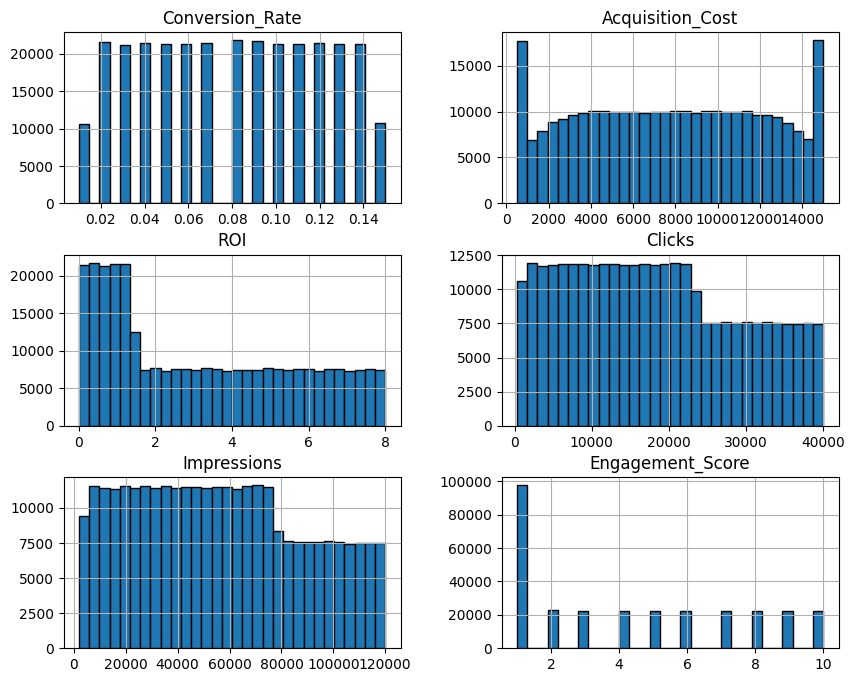

In [14]:
# Histogram pro numerické sloupce (bez Unnamed: 0, Campaign_ID a Date)
numerical_columns = df.select_dtypes(include=["number"]).columns.tolist()
exclude_columns = ["Unnamed: 0", "Campaign_ID"]
numerical_columns = [col for col in numerical_columns if col not in exclude_columns]

df[numerical_columns].hist(figsize=(10, 8), bins=30, edgecolor="black")

Histogramy numerických proměnných

- Většina metrik jako ROI, Clicks, Conversion Rate, Impressions a Engagement_Score má pravostranně zkosené rozložení – znamená to, že většina hodnot je relativně nízká, ale existuje několik kampaní s extrémně vysokými hodnotami.
- Conversion_Rate je velmi nízký u většiny kampaní, což je běžné u digitálního marketingu.
- Acquisition Cost má široké rozložení, což znamená, že některé kampaně byly velmi levné a jiné extrémně drahé.

Důležité poznatky:

- ROI a Acquisition Cost mají velký rozptyl, což naznačuje, že různé kampaně se chovají odlišně.
- Může být užitečné analyzovat extrémní hodnoty, abychom zjistili, proč některé kampaně byly mnohem úspěšnější nebo dražší než jiné.

### EDA: Analýza segmentů

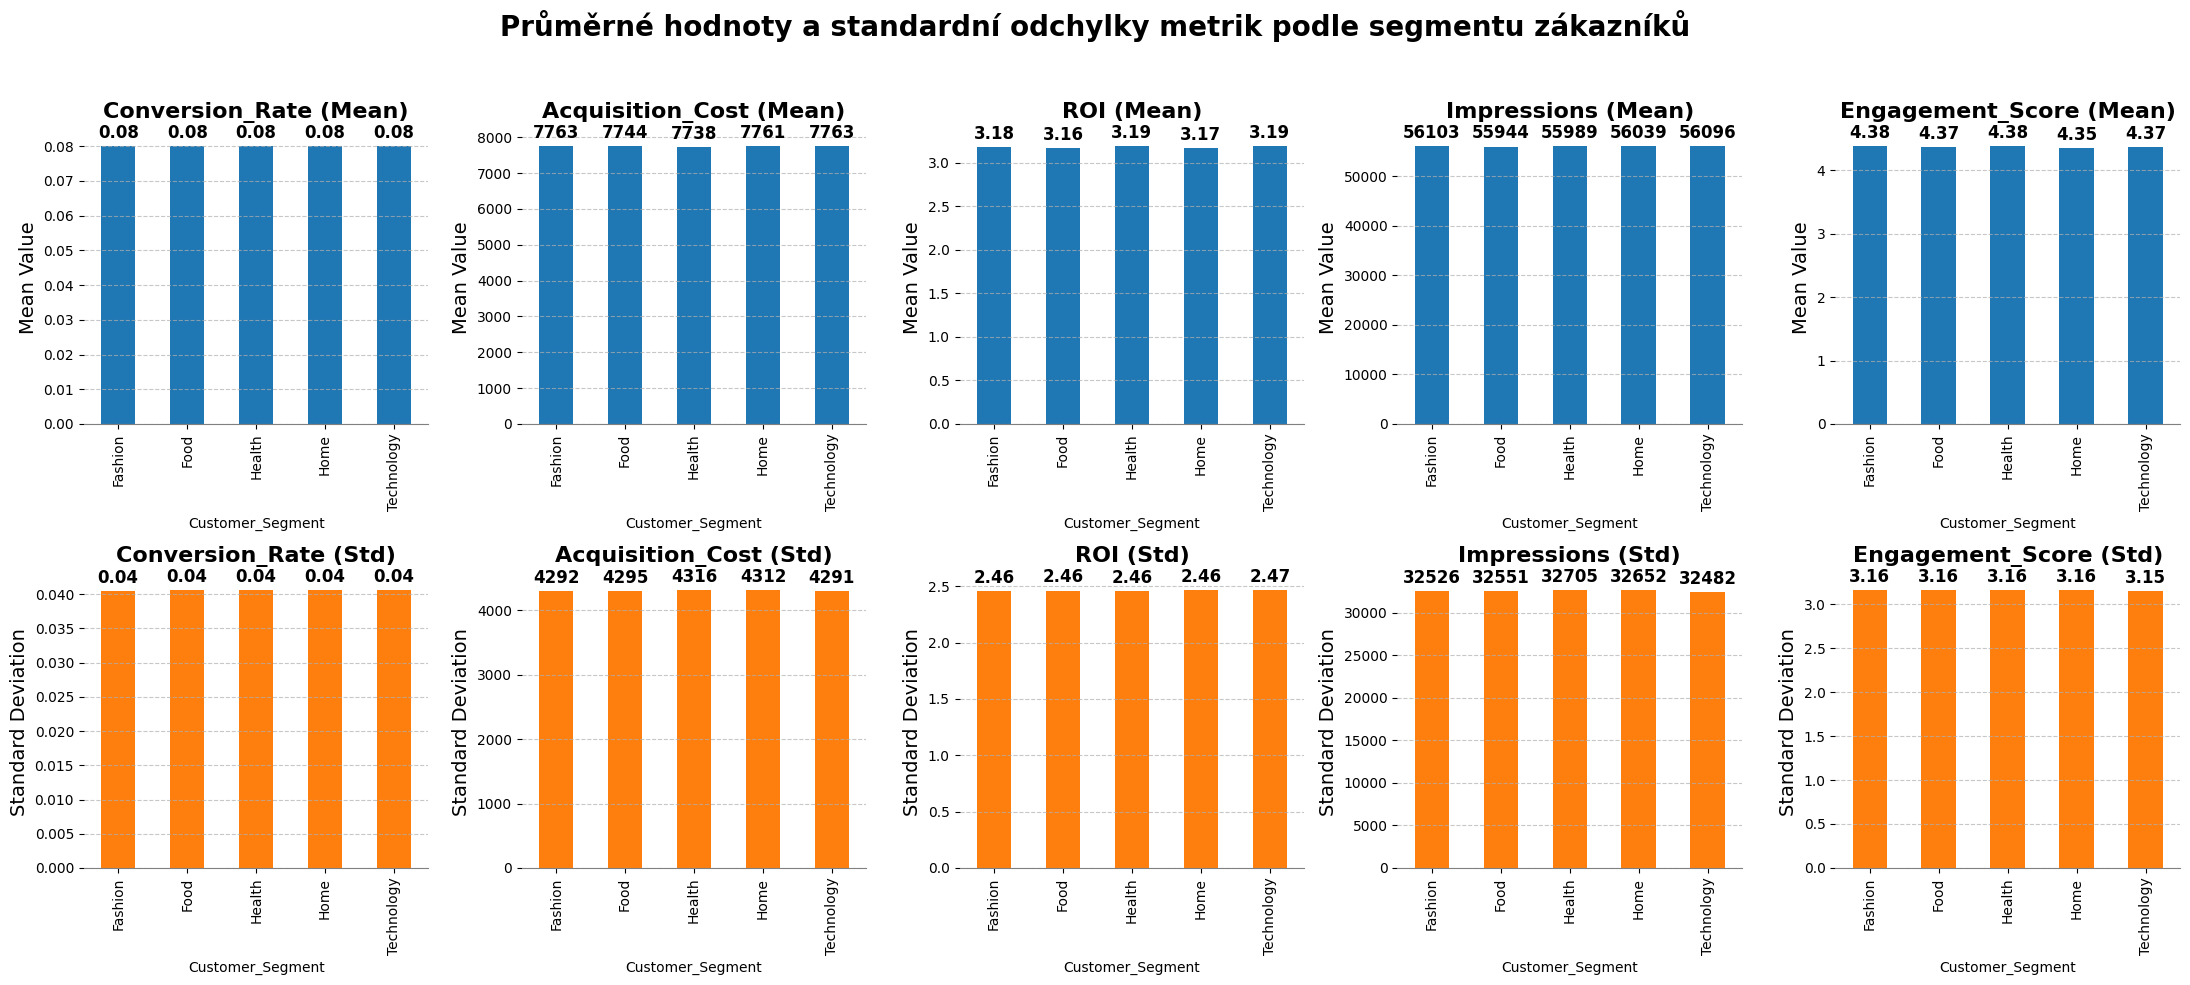

In [15]:
# Shrnutí metrik podle Customer_Segment
segment_summary = df.groupby("Customer_Segment").agg({
    "Conversion_Rate": ["mean", "std"],
    "Acquisition_Cost": ["mean", "std"],
    "ROI": ["mean", "std"],
    "Impressions": ["mean", "std"],
    "Engagement_Score": ["mean", "std"]
}).reset_index()

# Vykreslení sloupcových grafů s upravenou pozicí hodnot nad sloupci
fig, axes = plt.subplots(2, 5, figsize=(22, 10), facecolor='white')
fig.suptitle("Průměrné hodnoty a standardní odchylky metrik podle segmentu zákazníků", fontsize=20, fontweight='bold')

metrics = ["Conversion_Rate", "Acquisition_Cost", "ROI", "Impressions", "Engagement_Score"]
y_labels = ["Mean Value", "Standard Deviation"]
colors = ["#1f77b4", "#ff7f0e"]

# Vykreslení průměrů v první řadě grafů
for ax, metric in zip(axes[0], metrics):
    bars = segment_summary.plot(kind='bar', x="Customer_Segment", y=(metric, "mean"), ax=ax, legend=False, color=colors[0], edgecolor=None)
    ax.set_title(f"{metric} (Mean)", fontsize=16, fontweight='bold', pad=10)
    ax.set_ylabel(y_labels[0], fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Nastavení formátu hodnot
    if metric in ["Acquisition_Cost", "Impressions"]:
        fmt = "%.0f"  
    else:
        fmt = "%.2f"
    
    # Přidání hodnot nad sloupce s nižší pozicí
    for container in bars.containers:
        bars.bar_label(container, fmt=fmt, fontsize=12, padding=3, color='black', fontweight='bold', rotation=0)

# Vykreslení standardních odchylek ve druhé řadě grafů
for ax, metric in zip(axes[1], metrics):
    bars = segment_summary.plot(kind='bar', x="Customer_Segment", y=(metric, "std"), ax=ax, legend=False, color=colors[1], edgecolor=None)
    ax.set_title(f"{metric} (Std)", fontsize=16, fontweight='bold', pad=10)
    ax.set_ylabel(y_labels[1], fontsize=14)
    ax.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Nastavení formátu hodnot
    if metric in ["Acquisition_Cost", "Impressions"]:
        fmt = "%.0f"  
    else:
        fmt = "%.2f"
    
    # Přidání hodnot nad sloupce s nižší pozicí
    for container in bars.containers:
        bars.bar_label(container, fmt=fmt, fontsize=12, padding=3, color='black', fontweight='bold', rotation=0)

# Odebrání zbytečných okrajů
for ax in axes.flatten():
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_color("gray")

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()


Hlavní rozdíly mezi odvětvími:

Konverzní míra (Conversion Rate)
- Všechna odvětví mají podobné průměrné konverzní míry (~8 %).
- Rozdíly jsou minimální, což naznačuje, že konverze nezávisí silně na odvětví.

Náklady na akvizici (Acquisition Cost)
- Health má nejnižší průměrné náklady (~7 738 USD), Fashion a Technology nejvyšší (~7 763 USD).
- Rozdíly jsou opět velmi malé, což naznačuje podobné investice do reklamních kampaní.

Návratnost investic (ROI)
- Nejvyšší ROI má Health a Technology (3,19), nejnižší Food (3,16).
- Rozptyl je vysoký, což znamená, že jednotlivé kampaně mohou mít velmi rozdílné výsledky.

Zobrazení reklamy (Impressions)
- Počet zobrazení je podobný napříč odvětvími (v rozmezí ~55 900 – 56 100).
- Fashion má nejvyšší počet zobrazení (56 103), Food nejnižší (55 944).

Engagement Score (Zapojení uživatelů)
- Nejvyšší engagement mají Health (4,38) a Fashion (4,38).
- Nejnižší engagement má Home (4,35).
- Rozdíly jsou však minimální.

Shrnutí rozdílů v chování odvětví:
- Nejvyšší ROI má Technology a Health, ale rozdíly mezi odvětvími jsou malé.
- Konverzní míra a náklady na akvizici jsou téměř identické napříč odvětvími.
- Fashion a Health mají nejvyšší engagement, což naznačuje silnější interakci se zákazníky.
- Home segment má nejnižší engagement, což může znamenat menší zájem uživatelů o tento typ obsahu.

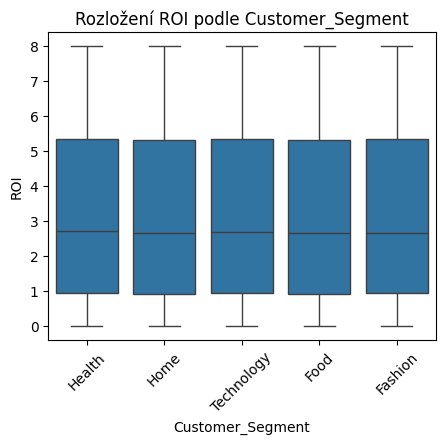

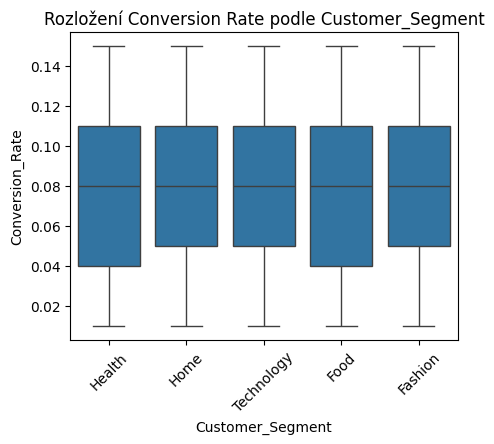

                      ROI                                                      \
                    count      mean       std  min       25%   50%   75%  max   
Customer_Segment                                                                
Fashion           59940.0  3.177892  2.458727  0.0  0.940211  2.66  5.33  8.0   
Food              60057.0  3.162724  2.460945  0.0  0.920000  2.65  5.31  8.0   
Health            60086.0  3.185992  2.456562  0.0  0.940000  2.70  5.34  8.0   
Home              60077.0  3.169546  2.462026  0.0  0.924123  2.65  5.32  8.0   
Technology        59840.0  3.192356  2.467713  0.0  0.932614  2.68  5.35  8.0   

                 Conversion_Rate                                              \
                           count      mean       std   min   25%   50%   75%   
Customer_Segment                                                               
Fashion                  59940.0  0.080100  0.040484  0.01  0.05  0.08  0.11   
Food                     60057.

In [16]:
# Boxplot pro ROI podle Customer_Segment
plt.figure(figsize=(5, 4))
sns.boxplot(data=df, x="Customer_Segment", y="ROI")
plt.title("Rozložení ROI podle Customer_Segment")
plt.xticks(rotation=45)
plt.show()

# Boxplot pro Conversion Rate podle Customer_Segment
plt.figure(figsize=(5, 4))
sns.boxplot(data=df, x="Customer_Segment", y="Conversion_Rate")
plt.title("Rozložení Conversion Rate podle Customer_Segment")
plt.xticks(rotation=45)
plt.show()

summary_stats = df.groupby("Customer_Segment")[["ROI", "Conversion_Rate"]].describe()

print(summary_stats)

Podle dat lze interpretovat jednotlivé části boxplotu takto:

**ROI**

- Medián (50 %): Středová hodnota ROI se pohybuje mezi 2,66 a 2,78 pro různé segmenty.
- Interkvartilové rozpětí (IQR, 25 % - 75 %):
    - Dolní kvartil (Q1, 25 %): kolem 0,92 - 0,94
    - Horní kvartil (Q3, 75 %): kolem 5,32 - 5,35
- To znamená, že 50  % hodnot leží mezi těmito dvěma hodnotami.
- Minimální hodnota (Min): ROI je 0.
- Maximální hodnota (Max): ROI dosahuje až 8,0.
- Směrodatná odchylka (std): Většina segmentů má hodnotu ~2,46. To naznačuje poměrně velkou variabilitu ROI mezi zákazníky.
- Průměr (Mean): Hodnoty ROI se pohybují mezi 3,16 - 3,19.

- ROI je silně rozprostřené (vysoký rozptyl) mezi různými zákaznickými segmenty.
- Polovina hodnot ROI spadá do širokého rozsahu 0,92 až 5,35, což značí vysokou variabilitu návratnosti investic.
- Outliery (pokud by byly vidět v boxplotu) by byly nad maximální hodnotou 8, což by mohlo značit několik velmi úspěšných kampaní.
- Největší průmerný ROI je pro segment Technology, ale rozdíly mezi segmenty nejsou dramatické.

**Conversion Rate**

- Medián (50 %): 0,08, což znamená, že polovina hodnot je pod 8 %.
- Interkvartilové rozpětí (IQR, 25 % - 75 %):
    - Dolní kvartil (Q1, 25 %): 0,04 - 0,05
    - Horní kvartil (Q3, 75 %): 0,11
- To znamená, že 50  % hodnot leží mezi 0,04 a 0,11.
- Minimální hodnota (Min): 0,01 – extrémně nízké conversion rate.
- Maximální hodnota (Max): 0,15 – nejvyšší konverzní poměr.
- Směrodatná odchylka (std): Malá variabilita ~0,04, což naznačuje, že většina hodnot je blízko průměru.
- Průměr (Mean): ~0,08, což odpovídá mediánu.

- Conversion Rate je poměrně stabilní mezi segmenty – nejsou zde velké rozdíly.
- Nejnižší hodnoty (0,01) ukazují, že některé kampaně nebo zákazníci konvertují velmi špatně.
- Rozpětí mezi 25 % a 75 % kvartilem je úzké, což znamená, že většina zákazníků má podobný konverzní poměr.
- Outliery (pokud by byly vidět v boxplotu) by byly blízko hodnoty 0,15.

Shrnutí hlavních rozdílů v chování odvětví:
- Všechny segmenty mají podobné výsledky ve výkonových metrikách ROI a Conversion Rate.
- Neexistuje žádné odvětví, které by jasně dominovalo nad ostatními.
- Rozdíly v metrikách jsou malé, ale mírně vyšší výsledky vykazují segmenty Technology a Fashion.


ANOVA pro vyhodnocení vztahu mezi zákaznickým segmentem a ROI a Conversion_Rate

In [17]:
# Korelace mezi Customer_Segment a výkonem kampaní
anova_roi_segment = stats.f_oneway(*[df[df["Customer_Segment"] == seg]["ROI"].dropna() for seg in df["Customer_Segment"].unique()])
anova_conv_segment = stats.f_oneway(*[df[df["Customer_Segment"] == seg]["Conversion_Rate"].dropna() for seg in df["Customer_Segment"].unique()])

| Metrika                                      | P-hodnota ANOVA | Interpretace                                      |
|----------------------------------------------|----------------|--------------------------------------------------|
| ROI podle Customer_Segment                   | 0.224          | Žádné statisticky významné rozdíly            |
| Conversion Rate podle Customer_Segment       | 0.916          | Konverzní míry jsou téměř identické napříč odvětvími |


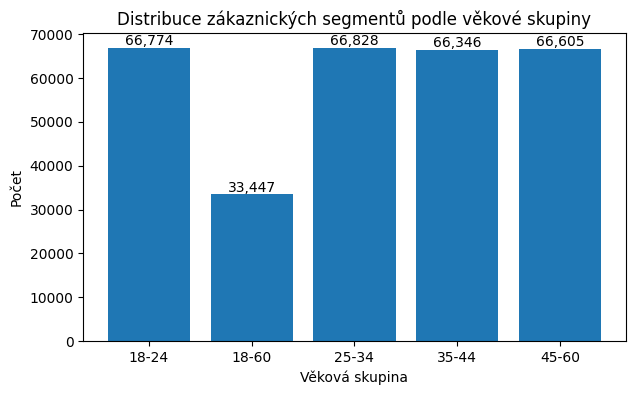

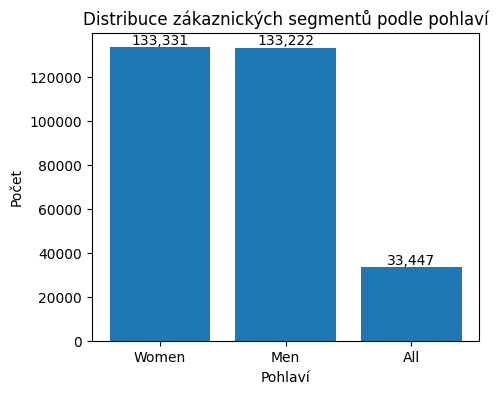

In [18]:
# První graf: Distribuce podle věkových skupin
plt.figure(figsize=(7, 4))
age_counts = df["Age_Group"].value_counts().sort_index()
bars = plt.bar(age_counts.index, age_counts.values)
plt.title("Distribuce zákaznických segmentů podle věkové skupiny")
plt.xlabel("Věková skupina")
plt.ylabel("Počet")
plt.xticks(rotation=0)

# Přidání hodnot nad sloupce
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{bar.get_height():,}", 
             ha='center', va='bottom', fontsize=10, rotation=0)

plt.show()

# Druhý graf: Distribuce podle pohlaví
plt.figure(figsize=(5, 4))
gender_counts = df["Gender"].value_counts()
bars = plt.bar(gender_counts.index, gender_counts.values)
plt.title("Distribuce zákaznických segmentů podle pohlaví")
plt.xlabel("Pohlaví")
plt.ylabel("Počet")
plt.xticks(rotation=0)

# Přidání hodnot nad sloupce
for bar in bars:
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height(), f"{bar.get_height():,}", 
             ha='center', va='bottom', fontsize=10, rotation=0)

plt.show()

1. Distribuce zákaznických segmentů podle věkové skupiny
- Věkové skupiny 18-24, 25-34, 35-44 a 45-60 jsou relativně vyrovnaně zastoupené.
- Největší skupinu tvoří zákazníci ve věku 25-34 let. To může znamenat, že tento segment je klíčový pro marketingové kampaně.
- Nejmenší zastoupení mají lidé ve věku 45-60 let, což může znamenat nižší zapojení této skupiny nebo menší cílení marketingových kampaní.
- Vzhledem k tomu, že mladší věkové skupiny (18-24, 25-34) mají vyšší zastoupení, lze předpokládat, že marketingová strategie je zaměřena primárně na mladší a digitálně aktivní publikum.

2. Distribuce zákaznických segmentů podle pohlaví
- Rozdělení mezi muži a ženami je relativně vyrovnané. To naznačuje, že kampaně nejsou zaměřeny výhradně na jedno pohlaví.
- Mírná převaha jedné skupiny (např. žen) by mohla znamenat, že určité produkty/služby mají větší popularitu mezi daným pohlavím.
- Rovnoměrnost distribuce může také ukazovat, že produkty/služby nejsou genderově specifické a oslovují široké spektrum zákazníků.

Shrnutí:
- Věková skupina 25-34 let je nejvíce zastoupená, což naznačuje, že jde o nejaktivnější a nejvíce cílený segment.
- Nižší zapojení zákazníků ve věku 45-60 let může ukazovat na menší zájem této skupiny o marketingové kampaně nebo odlišné nákupní chování.
- Vyrovnané zastoupení mužů a žen ukazuje na univerzální marketingovou strategii, která oslovuje obě pohlaví téměř rovnoměrně.

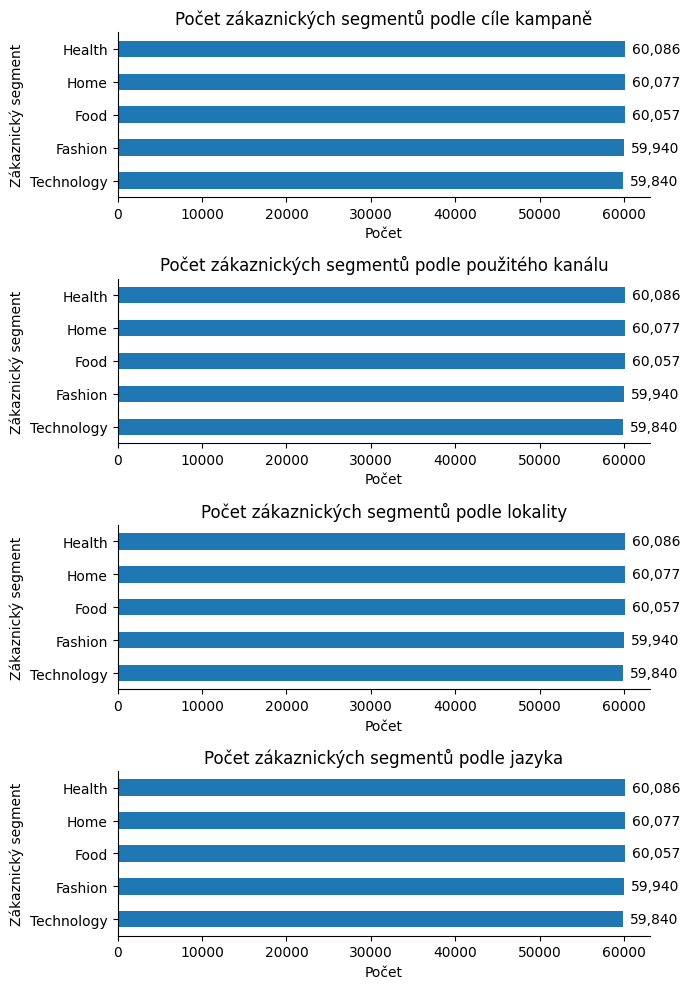

In [19]:
# Funkce pro přidání hodnot zaokrouhlených na celé číslo
def add_value_labels(ax):
    for p in ax.patches:
        value = int(round(p.get_width())) 
        ax.annotate(f'{value:,}', (p.get_width(), p.get_y() + p.get_height() / 2.), 
                    ha='left', va='center', fontsize=10, color='black', xytext=(5, 0), 
                    textcoords='offset points')


# Vytvoření podgrafů
fig, axes = plt.subplots(nrows=4, figsize=(7, 10))

# Počet zákaznických segmentů podle cíle kampaně
ax = axes[0]
kampane_pocty = df.groupby(["Customer_Segment", "Campaign_Goal"]).size().unstack().fillna(0)
kampane_pocty.sum(axis=1).sort_values().plot(kind="barh", ax=ax)
ax.set_title("Počet zákaznických segmentů podle cíle kampaně")
ax.set_xlabel("Počet")
ax.set_ylabel("Zákaznický segment")
add_value_labels(ax)

# Počet zákaznických segmentů podle použitého kanálu
ax = axes[1]
kanaly_pocty = df.groupby(["Customer_Segment", "Channel_Used"]).size().unstack().fillna(0)
kanaly_pocty.sum(axis=1).sort_values().plot(kind="barh", ax=ax)
ax.set_title("Počet zákaznických segmentů podle použitého kanálu")
ax.set_xlabel("Počet")
ax.set_ylabel("Zákaznický segment")
add_value_labels(ax)

# Počet zákaznických segmentů podle lokality
ax = axes[2]
lokality_pocty = df.groupby(["Customer_Segment", "Location"]).size().unstack().fillna(0)
lokality_pocty.sum(axis=1).sort_values().plot(kind="barh", ax=ax)
ax.set_title("Počet zákaznických segmentů podle lokality")
ax.set_xlabel("Počet")
ax.set_ylabel("Zákaznický segment")
add_value_labels(ax)

# Počet zákaznických segmentů podle jazyka
ax = axes[3]
jazyky_pocty = df.groupby(["Customer_Segment", "Language"]).size().unstack().fillna(0)
jazyky_pocty.sum(axis=1).sort_values().plot(kind="barh", ax=ax)
ax.set_title("Počet zákaznických segmentů podle jazyka")
ax.set_xlabel("Počet")
ax.set_ylabel("Zákaznický segment")
add_value_labels(ax)

# Odebrání horního a pravého rámu
for ax in axes.flatten():
    ax.spines["top"].set_visible(False) 
    ax.spines["right"].set_visible(False)

plt.tight_layout()
plt.show()

Počet zákaznických segmentů podle cíle kampaně:
- Hlavní cíle kampaní jsou rovnoměrně rozdělené mezi Brand Awareness, Increase Sales, Product Launch a Market Expansion.
- Všechny segmenty využívají tyto kampaně v podobné míře, což ukazuje na strategickou rovnováhu mezi růstem značky a prodejem.

Počet zákaznických segmentů podle použitého kanálu:
- Kanály jako Facebook, Instagram, Pinterest a Twitter jsou v každém segmentu široce využívané.
- To naznačuje, že žádný segment nedominoval v určitém kanálu – marketingová strategie se snaží pokrýt více platforem.

Počet zákaznických segmentů podle lokality:
- Kampaně byly rovnoměrně distribuovány mezi velká města jako Los Angeles, Miami, Austin, New York, Las Vegas.
- To naznačuje, že zaměření je hlavně na velkoměsta s vysokým tržním potenciálem.

Počet zákaznických segmentů podle jazyka:
- Angličtina, španělština a francouzština byly primární jazyky marketingových kampaní.
- To ukazuje na globální cílení, ale zároveň silné zaměření na severoamerický.

Shrnutí:
- Marketingová strategie je široce diverzifikovaná, bez výrazné dominance jednoho segmentu.
- Kampaně jsou rovnoměrně rozdělené mezi různé cílové skupiny, kampaně, kanály, lokality a jazyky.
- Zdá se, že marketingové úsilí je zaměřeno na maximalizaci dosahu a flexibilitu na různých trzích.

### EDA: Heatmapy (ROI a Conversion Rate)

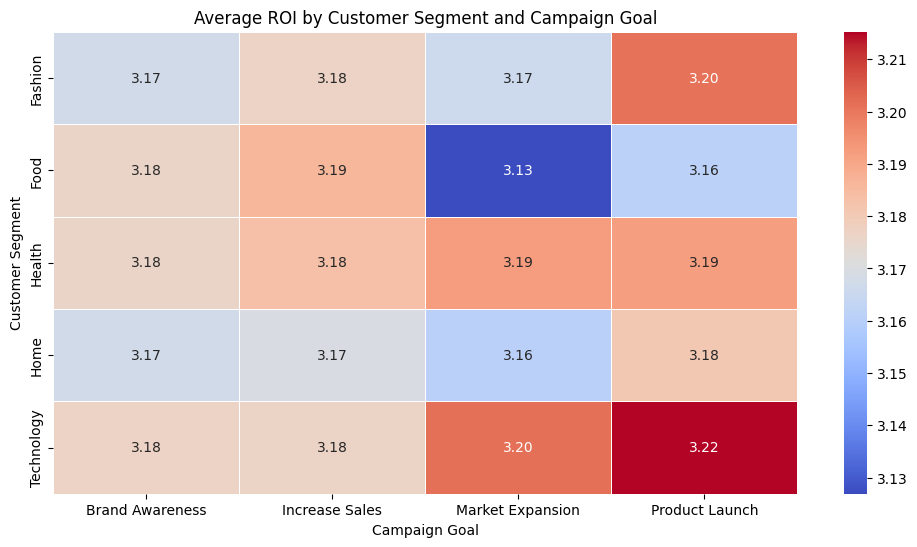

In [20]:
# Heatmapa: Průměrné ROI podle Customer_Segment a Campaign_Goal
plt.figure(figsize=(12, 6))
pivot_roi_goal = df.pivot_table(values="ROI", index="Customer_Segment", columns="Campaign_Goal", aggfunc="mean")
sns.heatmap(pivot_roi_goal, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Average ROI by Customer Segment and Campaign Goal")
plt.xlabel("Campaign Goal")
plt.ylabel("Customer Segment")
plt.show()

- Segmenty Fashion a Technology vykazují vyšší ROI u cíle Product Launch.
- Naopak některé segmenty mohou mít nízký ROI pro určité kampaně, což může naznačovat nevhodnou strategii.

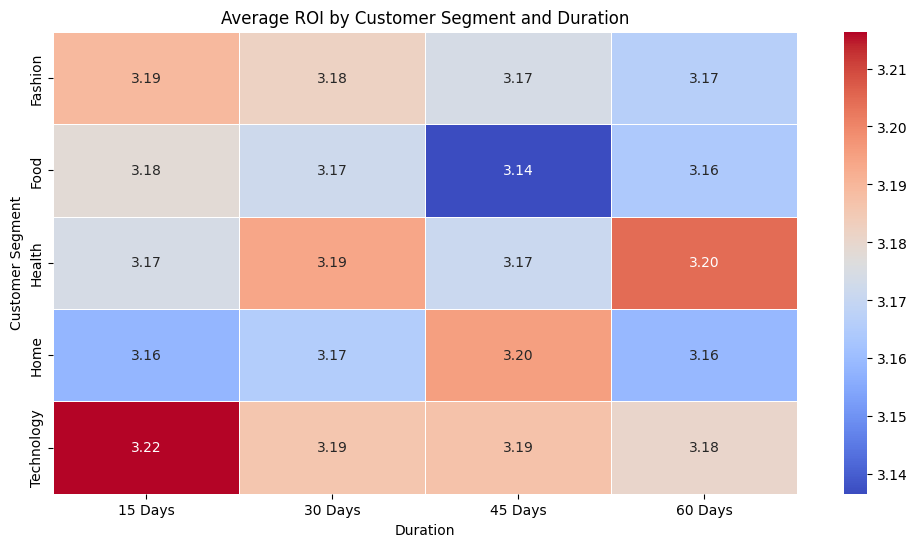

In [21]:
# Heatmapa: Průměrné ROI podle Customer_Segment a Duration
plt.figure(figsize=(12, 6))
pivot_roi_duration = df.pivot_table(values="ROI", index="Customer_Segment", columns="Duration", aggfunc="mean")
sns.heatmap(pivot_roi_duration, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Average ROI by Customer Segment and Duration")
plt.xlabel("Duration")
plt.ylabel("Customer Segment")
plt.show()

- Délka kampaně může mít vliv na ROI, některé segmenty mohou lépe fungovat s kratšími nebo delšími kampaněmi.
- Health segment vypadá lépe při delších kampaních (60 dnů), zatímco Technolgy dosahuje vyšší ROI u kratších kampaní (15 dnů).

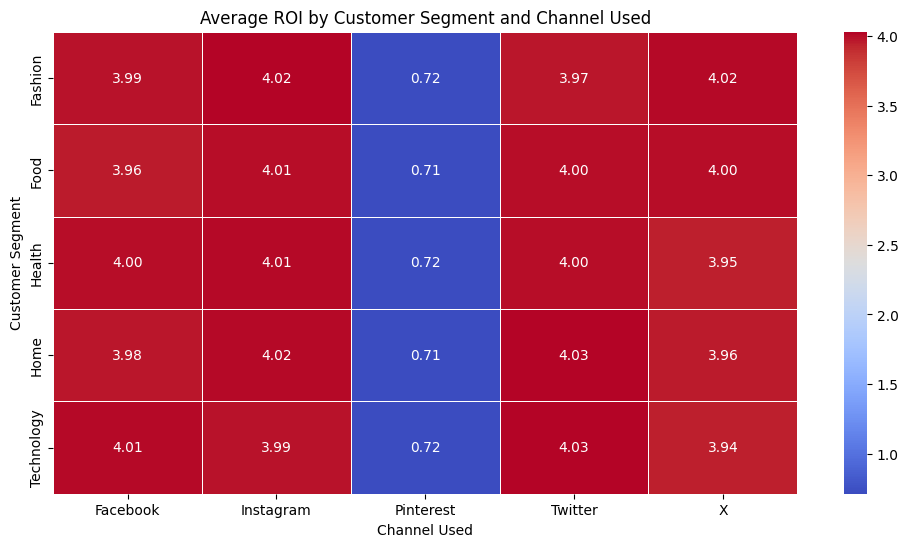

In [22]:
# Heatmapa: Průměrné ROI podle Customer_Segment a Channel_Used
plt.figure(figsize=(12, 6))
pivot_roi_channel = df.pivot_table(values="ROI", index="Customer_Segment", columns="Channel_Used", aggfunc="mean")
sns.heatmap(pivot_roi_channel, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Average ROI by Customer Segment and Channel Used")
plt.xlabel("Channel Used")
plt.ylabel("Customer Segment")
plt.show()

- Facebook, Instagram, Twitter a X mají vysoké ROI napříč všemi zákaznickými segmenty (hodnoty kolem 4).
- Zatímco investice do reklam na Pinterestu nejsou zdaleka tak efektivní jako u ostatních kanálů.

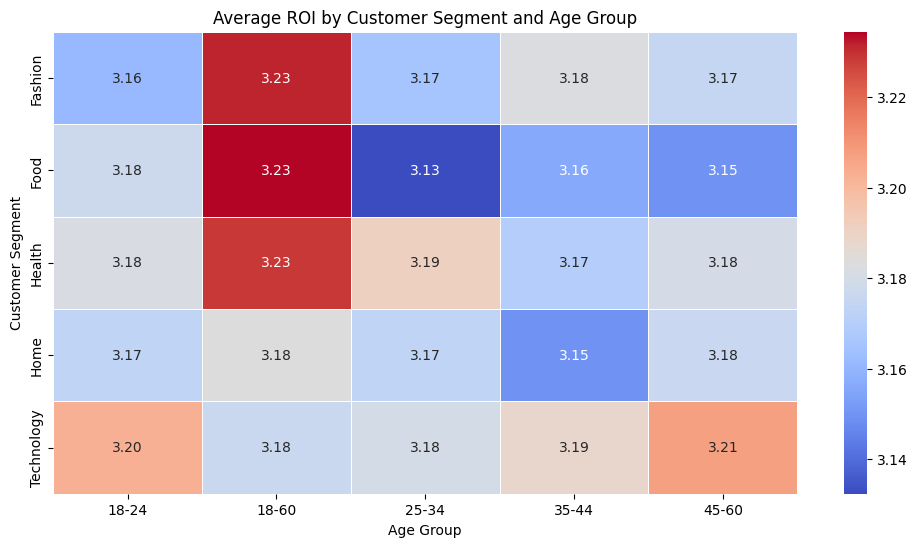

In [23]:
# Heatmapa: Průměrné ROI podle Customer_Segment a Age_Group
plt.figure(figsize=(12, 6))
pivot_roi_age = df.pivot_table(values="ROI", index="Customer_Segment", columns="Age_Group", aggfunc="mean")
sns.heatmap(pivot_roi_age, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Average ROI by Customer Segment and Age Group")
plt.xlabel("Age Group")
plt.ylabel("Customer Segment")
plt.show()

- Nejvyšší ROI (3,23) se vyskytuje u věkové skupiny 18-60 ve třech segmentech (Fashion, Food, Health). To naznačuje, že marketingové kampaně zaměřené na tuto širokou věkovou skupinu jsou v těchto segmentech nejefektivnější.
- Nejnižší ROI (3,13) se vyskytuje u segmentu Food ve věkové skupině 25-34.

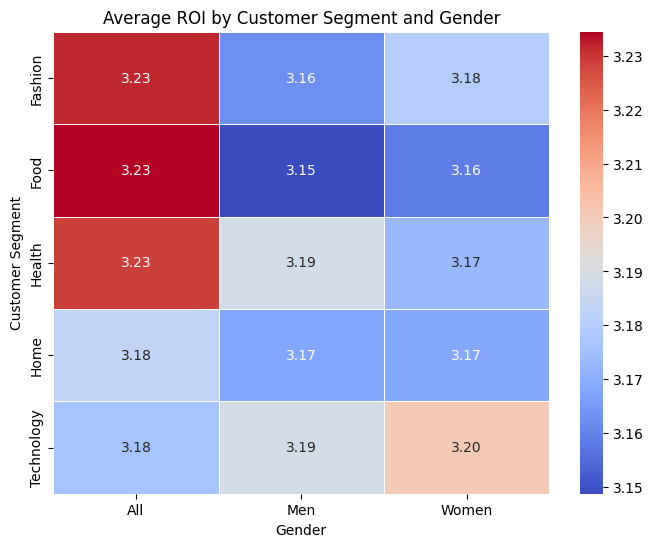

In [24]:
# Heatmapa: Průměrné ROI podle Customer_Segment a Gender
plt.figure(figsize=(8, 6))
pivot_roi_gender = df.pivot_table(values="ROI", index="Customer_Segment", columns="Gender", aggfunc="mean")
sns.heatmap(pivot_roi_gender, annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Average ROI by Customer Segment and Gender")
plt.xlabel("Gender")
plt.ylabel("Customer Segment")
plt.show()

- Nejvyšší ROI (3,23) se vyskytuje u segmentů Fashion, Food a Health ve skupině „All“. To naznačuje, že marketingové kampaně zaměřené na všechny pohlaví dohromady fungují nejlépe v těchto segmentech.
- Nejnižší ROI (3,15) se vyskytuje u segmentu Food pro muže. To může znamenat, že marketingové aktivity nejsou pro mužskou cílovou skupinu v tomto segmentu tak efektivní.

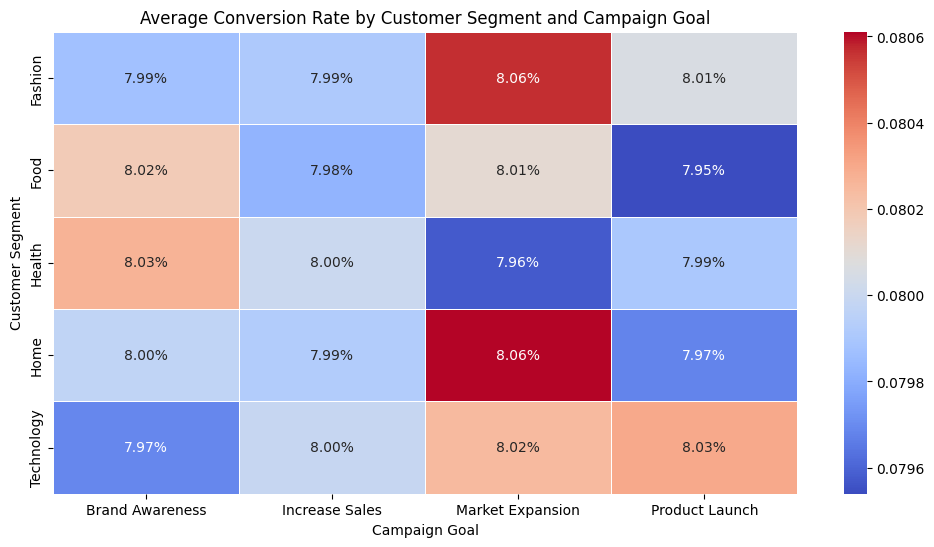

In [25]:
# Heatmapa: Průměrné Conversion Rate podle Customer_Segment a Campaign_Goal
plt.figure(figsize=(12, 6))
pivot_conv_goal = df.pivot_table(values="Conversion_Rate", index="Customer_Segment", columns="Campaign_Goal", aggfunc="mean")
sns.heatmap(pivot_conv_goal, annot=True, fmt=".2%", cmap="coolwarm", linewidths=0.5)
plt.title("Average Conversion Rate by Customer Segment and Campaign Goal")
plt.xlabel("Campaign Goal")
plt.ylabel("Customer Segment")
plt.show()

- Kampaně zaměřené na expanzi trhu (Market Expansion) mají vyšší konverzní míru v segmentech Home a Fashion.
- Kampaně zvyšující prodej (Increase Sales) dosahují stabilních výsledků ve všech segmentech, což naznačuje silnou zákaznickou odezvu v těchto kategoriích.

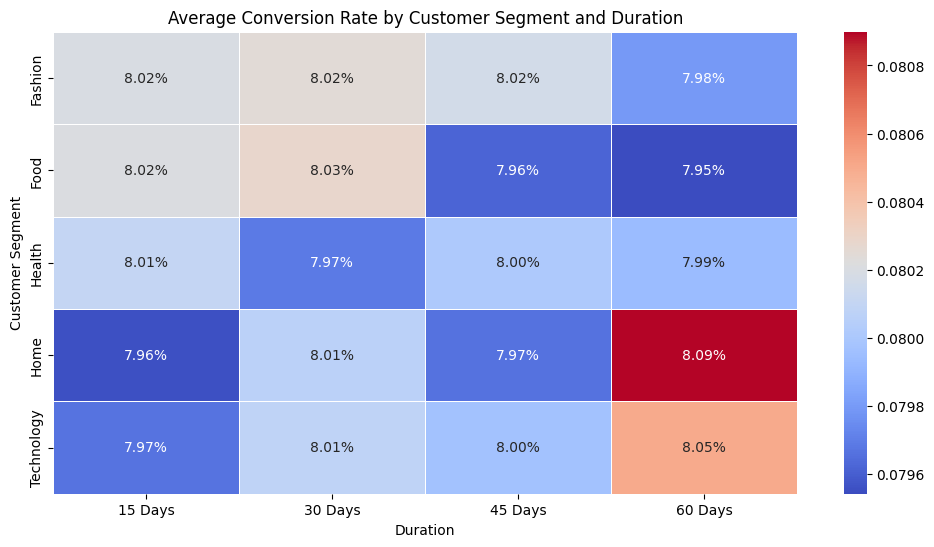

In [26]:
# Heatmapa: Průměrné Conversion Rate podle Customer_Segment a Duration
plt.figure(figsize=(12, 6))
pivot_conv_duration = df.pivot_table(values="Conversion_Rate", index="Customer_Segment", columns="Duration", aggfunc="mean")
sns.heatmap(pivot_conv_duration, annot=True, fmt=".2%", cmap="coolwarm", linewidths=0.5)
plt.title("Average Conversion Rate by Customer Segment and Duration")
plt.xlabel("Duration")
plt.ylabel("Customer Segment")
plt.show()

- Krátkodobé kampaně mají tendenci dosahovat mírně vyšší konverzní míry, zejména v segmentech Fashion a Food.
- Dlouhodobé kampaně fungují lépe v segmentech Home a Technology.

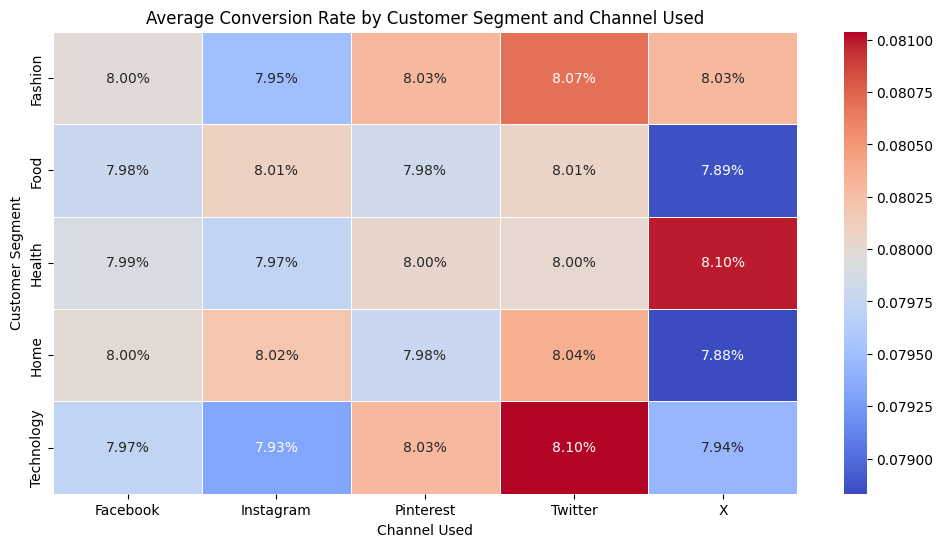

In [27]:
# Heatmapa: Průměrné Conversion Rate podle Customer_Segment a Channel_Used
plt.figure(figsize=(12, 6))
pivot_conv_channel = df.pivot_table(values="Conversion_Rate", index="Customer_Segment", columns="Channel_Used", aggfunc="mean")
sns.heatmap(pivot_conv_channel, annot=True, fmt=".2%", cmap="coolwarm", linewidths=0.5)
plt.title("Average Conversion Rate by Customer Segment and Channel Used")
plt.xlabel("Channel Used")
plt.ylabel("Customer Segment")
plt.show()


- Facebook vykazuje stabilní konverzní míry pro všechny segmenty (tj. okolo 8 %).
- Pinterest je efektivnější pro segmenty Fashion a Technology, což naznačuje specifickou účinnost této platformy.
- Twitter vykazuje celkově vyšší konverzní míry, což znamená, že může být nejvhodnější pro přímé konverze.

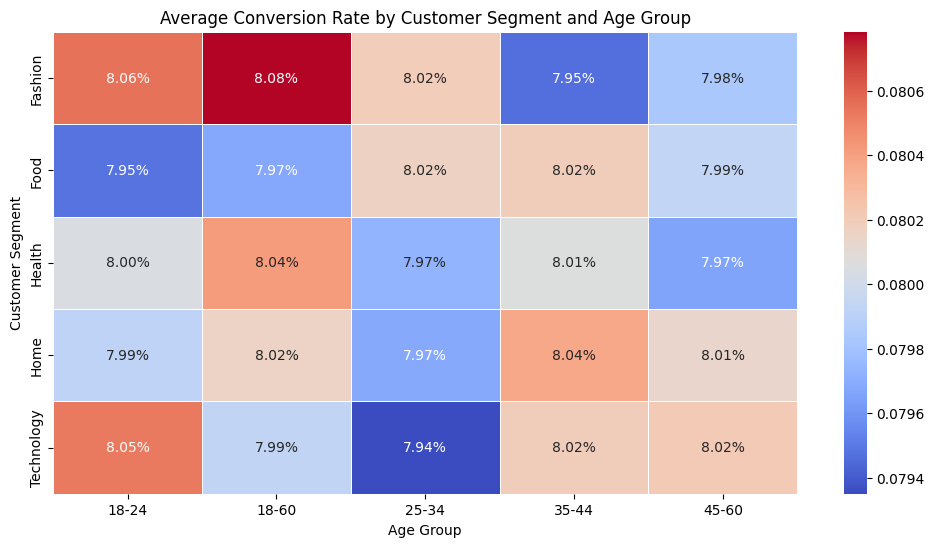

In [28]:
# Heatmapa: Průměrné Conversion Rate podle Customer_Segment a Age_Group
plt.figure(figsize=(12, 6))
pivot_conv_age = df.pivot_table(values="Conversion_Rate", index="Customer_Segment", columns="Age_Group", aggfunc="mean")
sns.heatmap(pivot_conv_age, annot=True, fmt=".2%", cmap="coolwarm", linewidths=0.5)
plt.title("Average Conversion Rate by Customer Segment and Age Group")
plt.xlabel("Age Group")
plt.ylabel("Customer Segment")
plt.show()

- Starší skupiny (45-60) vykazují nižší konverzní míru, pravděpodobně kvůli odlišným nákupním zvyklostem a chování online.
- Segmenty Technology a Fashion nejvíce profitují z věkové skupiny 18-24, což je očekávané, protože tyto odvětví oslovují především mladší publikum.

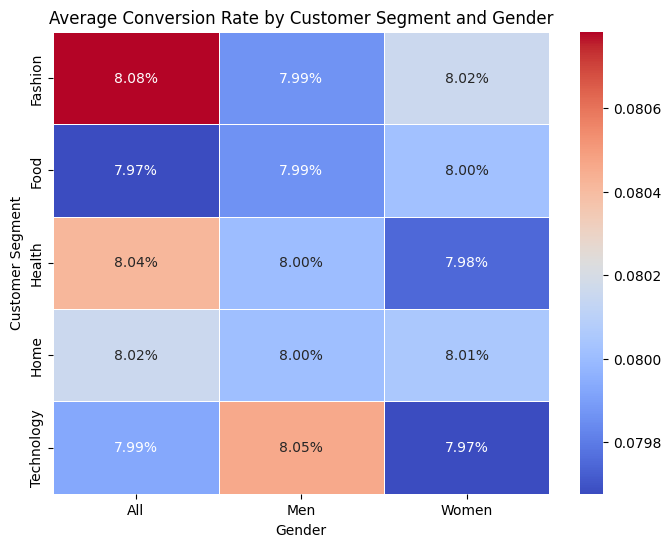

In [29]:
# Heatmapa: Průměrné Conversion Rate podle Customer_Segment a Gender
plt.figure(figsize=(8, 6))
pivot_conv_gender = df.pivot_table(values="Conversion_Rate", index="Customer_Segment", columns="Gender", aggfunc="mean")
sns.heatmap(pivot_conv_gender, annot=True, fmt=".2%", cmap="coolwarm", linewidths=0.5)
plt.title("Average Conversion Rate by Customer Segment and Gender")
plt.xlabel("Gender")
plt.ylabel("Customer Segment")
plt.show()

Ženy mají vyšší konverzní míry než muži v segmentech Fashion a Home, což naznačuje vyšší pravděpodobnost dokončení nákupu.
Muži vykazují mírně vyšší konverzní míru v segmentech Technology a Health, což ukazuje na rozdíly v nákupním chování mezi pohlavími.

### Analýza vybraného segmentu: Health

In [30]:
# Subset segmentu 'Health'
df_health = df[df["Customer_Segment"] == "Health"]

# Relevantní sloupce pro analýzu
df_health = df_health[["Channel_Used", "ROI", "Conversion_Rate", "Acquisition_Cost"]]

# Seskupení podle použitého kanálu a výpočet průměrných hodnot
df_health_grouped = df_health.groupby("Channel_Used").mean().reset_index()

# Nejlepší a nejhorší kanály podle ROI
best_roi_channel = df_health_grouped.loc[df_health_grouped["ROI"].idxmax()] 
worst_roi_channel = df_health_grouped.loc[df_health_grouped["ROI"].idxmin()] 

# Nejlepší a nejhorší kanály podle míry konverze
best_conversion_channel = df_health_grouped.loc[df_health_grouped["Conversion_Rate"].idxmax()]
worst_conversion_channel = df_health_grouped.loc[df_health_grouped["Conversion_Rate"].idxmin()] 

# Rozptyl ROI a míry konverze (rozsah výkonu)
roi_variance = np.var(df_health_grouped["ROI"])
conversion_variance = np.var(df_health_grouped["Conversion_Rate"])

# Poměr ROI k míře konverze (pro určení efektivity kanálů)
df_health_grouped["ROI_to_Conversion"] = df_health_grouped["ROI"] / df_health_grouped["Conversion_Rate"]

# Nejefektivnější a nejméně efektivní kanál
most_efficient_channel = df_health_grouped.loc[df_health_grouped["ROI_to_Conversion"].idxmax()] 
least_efficient_channel = df_health_grouped.loc[df_health_grouped["ROI_to_Conversion"].idxmin()]  

# Tabulka výsledků
evaluation_results = pd.DataFrame({
    "Metrika": [
        "Kanál s nejlepším ROI", "Kanál s nejhorším ROI",
        "Kanál s nejlepší mírou konverze", "Kanál s nejhorší mírou konverze",
        "Rozptyl ROI", "Rozptyl míry konverze",
        "Nejefektivnější kanál (ROI na konverzi)", "Nejméně efektivní kanál (ROI na konverzi)"
    ],
    "Hodnota": [
        best_roi_channel["Channel_Used"], worst_roi_channel["Channel_Used"],
        best_conversion_channel["Channel_Used"], worst_conversion_channel["Channel_Used"],
        roi_variance, conversion_variance,
        most_efficient_channel["Channel_Used"], least_efficient_channel["Channel_Used"]
    ]
})

# Výsledky
display(evaluation_results)


,Metrika,Hodnota
0,Kanál s nejlepším ROI,Instagram
1,Kanál s nejhorším ROI,Pinterest
2,Kanál s nejlepší mírou konverze,X
3,Kanál s nejhorší mírou konverze,Instagram
4,Rozptyl ROI,1.715875
5,Rozptyl míry konverze,0.0
6,Nejefektivnější kanál (ROI na konverzi),Instagram
7,Nejméně efektivní kanál (ROI na konverzi),Pinterest


Doporučení:
1. Instagram je nejvýnosnější kanál, ale jeho míra konverze je nízká. Možná by pomohlo optimalizovat obsah nebo zacílení kampaní ke zvýšení konverzního poměru.
2. Pinterest se jeví jako nejméně výhodná investice a bylo by vhodné zvážit jeho omezení nebo optimalizaci strategie.
3. X má nejlepší konverzní poměr, což ukazuje, že oslovuje správné publikum, ale ROI nemusí být tak vysoké. 
4. Celkově je třeba se zaměřit na strategie, které zvýší konverze na Instagramu a zároveň zvážit efektivitu investic do Pinterestu.

In [31]:
# Analýza výkonu Instagramu detailněji
df_instagram = df_health[df_health["Channel_Used"] == "Instagram"]

# Rozložení ROI a míry konverze pro kampaně na Instagramu
roi_instagram_avg = df_instagram["ROI"].mean()
conversion_instagram_avg = df_instagram["Conversion_Rate"].mean()

# Vztah mezi ROI a mírou konverze pro Instagram
correlation_instagram = df_instagram["ROI"].corr(df_instagram["Conversion_Rate"])

# Ověření, zda vysoké ROI na Instagramu není způsobeno extrémními hodnotami (outliery)
roi_outliers_instagram = df_instagram[df_instagram["ROI"] > df_instagram["ROI"].quantile(0.95)]  

# Srovnání průměrných nákladů na získání zákazníka (Acquisition Cost) pro Instagram vs. ostatní kanály
avg_acquisition_cost_instagram = df_health[df_health["Channel_Used"] == "Instagram"]["Acquisition_Cost"].mean()

# Průměrné náklady na získání zákazníka pro ostatní kanály
avg_acquisition_cost_other = df_health[df_health["Channel_Used"] != "Instagram"]["Acquisition_Cost"].mean()

print(f"""Shrnutí metrik pro Instagram

Průměrné ROI na Instagramu: {roi_instagram_avg:.2f}
Průměrná konverzní míra na Instagramu: {conversion_instagram_avg:.2%}
Korelace mezi ROI a konverzní mírou: {correlation_instagram:.2f}
Počet ROI odlehlých hodnot na Instagramu (Top 5 %): {len(roi_outliers_instagram)}
Průměrné akviziční náklady na Instagramu: {avg_acquisition_cost_instagram:.2f}
Průměrné akviziční náklady na ostatních kanálech: {avg_acquisition_cost_other:.2f}""")

Shrnutí metrik pro Instagram

Průměrné ROI na Instagramu: 4.01
Průměrná konverzní míra na Instagramu: 7.97%
Korelace mezi ROI a konverzní mírou: -0.00
Počet ROI odlehlých hodnot na Instagramu (Top 5 %): 758
Průměrné akviziční náklady na Instagramu: 7727.55
Průměrné akviziční náklady na ostatních kanálech: 7741.62


Proč má Instagram nejvyšší ROI, ale zároveň nejnižší konverzní míru:

- Vysoké ROI díky odlehlým hodnotám:
Na Instagramu existuje 758 kampaní, které patří do horních 5 % podle ROI, což znamená, že některé kampaně dosahují výjimečných výsledků a zkreslují průměr.

- Neexistuje silná korelace mezi ROI a konverzní mírou:
Korelační koeficient je téměř nulový (-0,00049), což naznačuje, že vyšší ROI nemusí nutně znamenat lepší konverzní míru.

- Nižší konverzní míra i přes vysoké ROI:
To může znamenat, že kampaně na Instagramu generují vysoké příjmy, ale relativně málo konverzí, pravděpodobně z těchto důvodů:
    - Vyšší výdaje na jednu konverzi
    - Inzerují se dražší produkty
    - Vyšší průměrná hodnota nákupu na zákazníka

Akviziční náklady jsou podobné napříč kanály:
- Průměrné akviziční náklady na Instagramu (7 727 dolarů) jsou téměř stejné jako u ostatních kanálů (7 741 dolarů), což znamená, že rozdíl v ROI není způsoben snížením nákladů.

### Hypotézy pro segment Health

Hypotézy vycházejí z korelačních matic.
1. Průměr ROI pro Health u 15 dní je 3,17, zatímco u 60 dní je 3,20.
2. Průměr konverzní míry pro Health u mužů je 8 %, zatímco žen je 7,98 %.
3. Mladší věkové skupiny (18-34) generují vyšší ROI (3,18 a 3,19 X 3,17 a 3,18).

Vzhledem k povaze dat jde spíše o myšlenkové cvičení než o směrodatnou analýzu.

In [32]:
# Definujeme df_health pouze pro segment "Health" jako kopii
df_health = df[df["Customer_Segment"] == "Health"].copy()

# Hypotéza 1: Dlouhodobé kampaně (60 dní) mají vyšší ROI než krátkodobé (15 dní) (t-test)
df_health["Duration"] = df_health["Duration"].str.replace(" Days", "").astype(int)

# Skupiny pro krátkodobé (15 dní) a dlouhodobé (60 dní) kampaně
short_term = df_health[df_health["Duration"]== 15]["ROI"].dropna()
long_term = df_health[df_health["Duration"] == 60]["ROI"].dropna()

# t-test mezi dlouhodobými a krátkodobými kampaněmi
anova_test_duration = stats.ttest_ind(long_term, short_term)

# Hypotéza 2: Muži mají vyšší konverzní poměr než ženy (t-test)
men_conv = df_health[df_health["Gender"] == "Men"]["Conversion_Rate"].dropna()
women_conv = df_health[df_health["Gender"] == "Women"]["Conversion_Rate"].dropna()

# t-test mezi muži a ženami
t_test_gender = stats.ttest_ind(men_conv, women_conv)

# Hypotéza 3: Mladší věkové skupiny (18-34) generují vyšší ROI (ANOVA test)
young_group = df_health[df_health["Age_Group"].isin(["18-24", "25-34"])]["ROI"].dropna()
older_group = df_health[df_health["Age_Group"].isin(["35-44", "45-60"])]["ROI"].dropna()

# ANOVA test mezi mladšími a staršími skupinami
anova_test_age = stats.f_oneway(young_group, older_group)

# Tabulky výsledků
results = pd.DataFrame({
    "Hypotéza": [
                "Dlouhodobé kampaně (60 dní) mají vyšší ROI",
                "Muži mají vyšší konverzní poměr než ženy",
                "Mladší věkové skupiny (18-34) generují vyšší ROI"
    ],
    "P-hodnota": [
        anova_test_duration.pvalue,
        t_test_gender.pvalue,
        anova_test_age.pvalue
    ],
    "Interpretace": [
        "Statisticky významné rozdíly" if anova_test_duration.pvalue < 0.05 else "Žádné statisticky významné rozdíly",
        "Statisticky významné rozdíly" if t_test_gender.pvalue < 0.05 else "Žádné statisticky významné rozdíly",
        "Statisticky významné rozdíly" if anova_test_age.pvalue < 0.05 else "Žádné statisticky významné rozdíly"
    ]
})

# Výsledky
display(results)

,Hypotéza,P-hodnota,Interpretace
0,Dlouhodobé kampaně (60 dní) mají vyšší ROI,0.286582,Žádné statisticky významné rozdíly
1,Muži mají vyšší konverzní poměr než ženy,0.474150,Žádné statisticky významné rozdíly
2,Mladší věkové skupiny (18-34) generují vyšší ROI,0.588625,Žádné statisticky významné rozdíly


Interpretace jednotlivých hypotéz
1. Dlouhodobé kampaně (60 dní) mají vyšší ROI než krátkodobé (15 dní)
- p-hodnota: 0.2866 (vyšší než 0.05)
- Interpretace: Neexistuje statisticky významný rozdíl mezi ROI krátkodobých (15 dní) a dlouhodobých (60 dní) kampaní. Ačkoli ROI dlouhodobých kampaní bylo v průměru o něco vyšší, rozdíl není natolik velký, aby mohl být považován za statisticky prokazatelný.
2. Hypotéza: Muži mají vyšší konverzní poměr než ženy
- p-hodnota: 0.4715 (vyšší než 0.05)
- Interpretace: Neexistuje statisticky významný rozdíl mezi konverzními poměry mužů a žen. Rozdíl mezi 8 % (muži) vs. 7.98 % (ženy) je extrémně malý a v rámci statistické chyby. Nelze tedy říct, že jedno pohlaví má významně vyšší konverzní poměr než druhé.
3. Hypotéza: Mladší věkové skupiny (18-34) generují vyšší ROI než starší skupiny
- p-hodnota: 0.5886 (vyšší než 0.05)
- Interpretace: Neexistuje statisticky významný rozdíl mezi ROI mladších (18-34) a starších (35+). I když průměrné ROI bylo o něco vyšší pro mladší skupinu, tento rozdíl je tak malý, že se pravděpodobně vyskytl náhodně.

### Health z demografického pohledu

In [33]:
# Identifikace nejvýkonnějších demografických skupin pro doporučení cílených kampaní

# Definujeme df_health pouze pro segment "Health"
df_health = df[df["Customer_Segment"] == "Health"]

# Seskupení podle věkové skupiny a pohlaví pro analýzu výkonu
df_demographic_analysis = df_health.groupby(["Age_Group", "Gender"])[["ROI", "Conversion_Rate"]].mean().reset_index()

# Zobrazení analýzy výkonu kampaní podle demografických skupin
print(df_demographic_analysis)

# Nalezení demografických skupin s nejvyšším ROI a konverzní mírou
best_roi_group = df_demographic_analysis.loc[df_demographic_analysis["ROI"].idxmax()]
best_conversion_group = df_demographic_analysis.loc[df_demographic_analysis["Conversion_Rate"].idxmax()]

# Nalezení demografických skupin s nejnižším ROI a konverzní mírou
worst_roi_group = df_demographic_analysis.loc[df_demographic_analysis["ROI"].idxmin()]
worst_conversion_group = df_demographic_analysis.loc[df_demographic_analysis["Conversion_Rate"].idxmin()]

# Vytvoření doporučení pro cílené kampaně
campaign_recommendations = pd.DataFrame({
    "Doporučení": [
        "Zacílit na skupinu s vysokým ROI prémiovými produkty a retargetingovou strategií.",
        "Optimalizovat konverzně zaměřené kampaně pro vysoce konvertující publikum.",
        "Přepracovat marketingovou strategii pro publikum s nízkým ROI (např. úprava cen, přizpůsobení produktů, změna komunikace).",
        "Zlepšit optimalizaci konverzí pro publikum s nízkou konverzní mírou (např. lepší uživatelská cesta, A/B testování)."
    ],
    "Demografická skupina": [
        f"{best_roi_group['Gender']} {best_roi_group['Age_Group']}",
        f"{best_conversion_group['Gender']} {best_conversion_group['Age_Group']}",
        f"{worst_roi_group['Gender']} {worst_roi_group['Age_Group']}",
        f"{worst_conversion_group['Gender']} {worst_conversion_group['Age_Group']}"
    ],
    "Metrika": ["ROI", "Konverzní míra", "ROI", "Konverzní míra"],
    "Hodnota": [best_roi_group["ROI"], best_conversion_group["Conversion_Rate"],
                worst_roi_group["ROI"], worst_conversion_group["Conversion_Rate"]]
})

# Zobrazení doporučení pro cílené kampaně
display(campaign_recommendations)

  Age_Group Gender       ROI  Conversion_Rate
0     18-24    Men  3.235733         0.080228
1     18-24  Women  3.129950         0.079871
2     18-60    All  3.228696         0.080417
3     25-34    Men  3.178509         0.079876
4     25-34  Women  3.203444         0.079584
5     35-44    Men  3.163885         0.079634
6     35-44  Women  3.175217         0.080493
7     45-60    Men  3.175671         0.080272
8     45-60  Women  3.184579         0.079056


,Doporučení,Demografická skupina,Metrika,Hodnota
0,Zacílit na skupinu s vysokým ROI prémiovými pr...,Men 18-24,ROI,3.235733
1,Optimalizovat konverzně zaměřené kampaně pro v...,Women 35-44,Konverzní míra,0.080493
2,Přepracovat marketingovou strategii pro publik...,Women 18-24,ROI,3.129950
3,Zlepšit optimalizaci konverzí pro publikum s n...,Women 45-60,Konverzní míra,0.079056


### Modelování 

Model bude testován pomocí standardních regresních metrik, které ukazují jeho přesnost a schopnost predikovat návratnost investic (**ROI**).  

In [34]:
# Načtení datové sady znovu
file_path = "Case_Study_DS_PG 1.csv"
df = pd.read_csv(file_path)

# Filtrování datové sady pro segment zákazníků "Health" (explicitně vytvoříme kopii)
df_health = df[df["Customer_Segment"] == "Health"].copy()

# Oprava všech nesprávných hodnot v Target_Audience
df_health.loc[:, "Target_Audience"] = df_health["Target_Audience"].replace({
    "W 18-24": "Women 18-24",
    "W 45-60": "Women 45-60",
    "W 25-34": "Women 25-34",
    " W o m e n   3 5 - 4 4 ": "Women 35-44",
    "W 35-44": "Women 35-44",
    "Men 18 -24": "Men 18-24",
    "Women 35.44": "Women 35-44",
    "Women   18-24": "Women 18-24",
    " W o m e n   2 5 - 3 4 ": "Women 25-34",
    "Men   25-34": "Men 25-34",
    "Men   18-24": "Men 18-24",
    "Women   45-60": "Women 45-60",
    "Men 25 -34": "Men 25-34",
    "Men 45 -60": "Men 45-60",
    "Women   25-34": "Women 25-34",
    "Women 25 -34": "Women 25-34",
    "men 25-34": "Men 25-34",
    "men 18-24": "Men 18-24",
    "men 45-60": "Men 45-60",
    "All Ages": "18-60"
})


# Rozdělit sloupec 'Target_Audience' na 'Age_Group' a 'Gender'
df_health.loc[:, "Age_Group"] = df_health["Target_Audience"].str.extract(r'(\d{2}-\d{2})')

# Nahradit chybějící hodnoty ve sloupci 'Gender' hodnotou "All" (pro skupinu "18-60")
df_health.loc[:, "Gender"] = df_health["Target_Audience"].str.extract(r'(Men|Women)')

# Doplnění chybějících hodnot ve sloupci Gender hodnotou "All" (pro případy, kdy nelze určit pohlaví)
df_health.loc[:, "Gender"] = df_health["Gender"].fillna("All")

# Odstranění znaku dolaru ($) ve sloupci 'Acquisition_Cost' a převedení na datový typ float
df_health.loc[:, "Acquisition_Cost"] = df_health["Acquisition_Cost"].replace(r'[$,]', '', regex=True).astype(float)

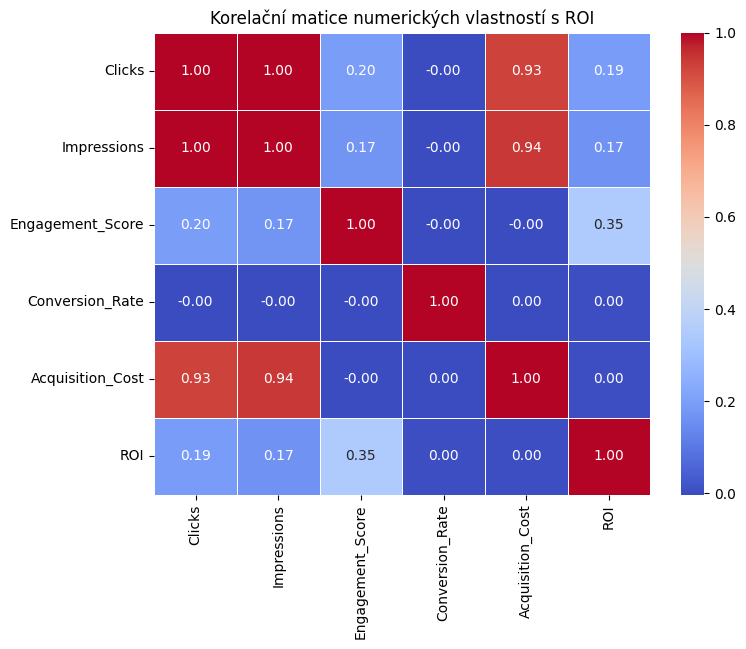

ROI                 1.000000
Engagement_Score    0.348836
Clicks              0.190034
Impressions         0.167984
Acquisition_Cost    0.002295
Conversion_Rate     0.001430
Name: ROI, dtype: float64

In [35]:
# Výpočet korelační matice včetně dalších numerických vlastností
numeric_features_health = ["Clicks", "Impressions", "Engagement_Score", "Conversion_Rate", "Acquisition_Cost", "ROI"]
df_corr_extended = df_health[numeric_features_health].corr()

# Heatmapa pro rozšířené numerické vlastnosti
plt.figure(figsize=(8, 6))
sns.heatmap(df_corr_extended, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Korelační matice numerických vlastností s ROI")
plt.show()

# Výpočet korelačních hodnot specificky s ROI
df_corr_extended["ROI"].sort_values(ascending=False)

Korelační analýza ROI

1. Pozitivně korelované proměnné (vyšší hodnota → vyšší ROI)

- **Engagement_Score (+0.3488)**  
  - Nejsilnější pozitivní korelace s ROI. To znamená, že čím vyšší **Engagement Score**, tím vyšší **ROI**.  
  - Pokud je cílem zlepšit návratnost investic, měla by se zvýšit uživatelská angažovanost (např. skrze **lepší obsah** nebo **personalizaci**).

- **Clicks (+0.1900)**  
  - Slabší, ale stále pozitivní korelace. Více **kliknutí** obvykle znamená vyšší **ROI**, ale není to nejsilnější faktor.  
  - Pravděpodobně záleží na **kvalitě kliknutí** (konverze).

- **Impressions (+0.1680)**  
  - Velmi podobná situace jako u kliknutí – více **zobrazení** může zvýšit **ROI**, ale efekt není příliš silný.  
  - Možná záleží na tom, zda jsou **zobrazení cílená na správné publikum**.

2. Téměř nekorelované proměnné (nevýznamný vliv na ROI)

-  **Acquisition_Cost (+0.0023)**  
    - Téměř nulová korelace → cena za získání zákazníka pravděpodobně nemá velký vliv na **ROI**.  
    - Možná se náklady na akvizici **pohybují ve stálém rozmezí**, nebo jsou **ROI a náklady vyvážené**.

-  **Conversion_Rate (+0.0014)**  
    - Velmi slabá pozitivní korelace. To je překvapivé, protože by se dalo očekávat, že **vyšší konverzní poměr** bude znamenat **vyšší ROI**.  
    - Možná existují další faktory (např. **zisk na konverzi je nízký**, nebo jsou **kampaně drahé**).

3. Klíčové poznatky

  - **Engagement Score je nejsilnějším prediktorem ROI** – zvýšená **interakce** vede k vyšší **návratnosti investic**.
  - **Cena akvizice a konverzní poměr prakticky neovlivňují ROI**, což naznačuje, že **ROI není přímo závislá na efektivitě nákladů nebo konverzní míře**.
  - **Clicks a Impressions mezi sebou korelují.** To znamená, že obě featury mají velmi podobný vliv na ROI.  
    - **Ponecháme Clicks**, protože přímo souvisí s **uživatelskou akcí**.


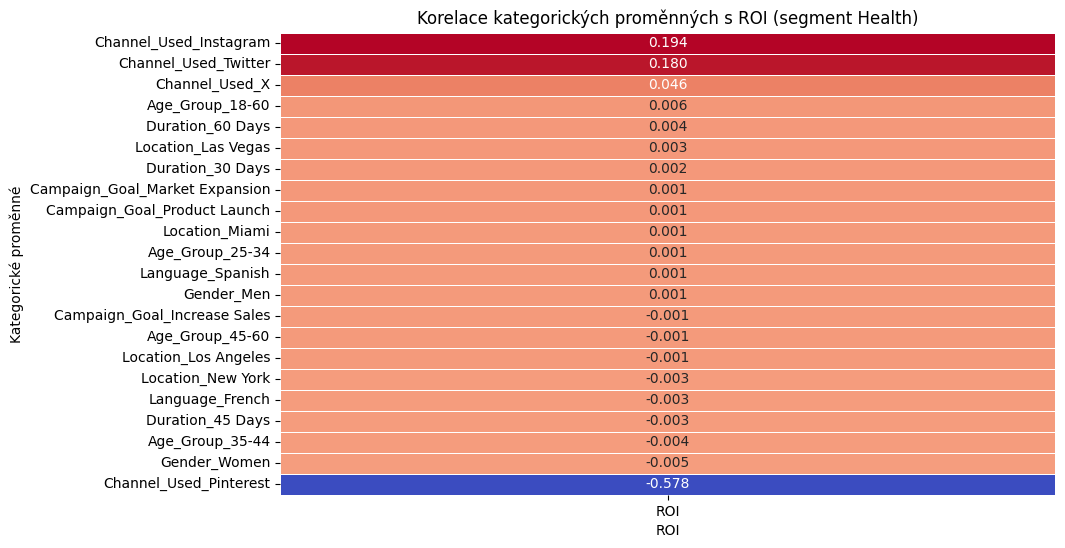

Channel_Used_Instagram            0.194355
Channel_Used_Twitter              0.180106
Channel_Used_X                    0.046006
Age_Group_18-60                   0.006156
Duration_60 Days                  0.004348
Location_Las Vegas                0.003276
Duration_30 Days                  0.001844
Campaign_Goal_Market Expansion    0.001476
Campaign_Goal_Product Launch      0.001442
Location_Miami                    0.001188
Age_Group_25-34                   0.001093
Language_Spanish                  0.000812
Gender_Men                        0.000810
Campaign_Goal_Increase Sales     -0.000600
Age_Group_45-60                  -0.001274
Location_Los Angeles             -0.001424
Location_New York                -0.002538
Language_French                  -0.002924
Duration_45 Days                 -0.003453
Age_Group_35-44                  -0.003558
Gender_Women                     -0.004704
Channel_Used_Pinterest           -0.577572
Name: ROI, dtype: float64

In [36]:
# Vyfiltrovat nerelevantní sloupce
df_health_filtered = df_health.drop(columns=["Unnamed: 0", "Campaign_ID", "Date", "Company", "Target_Audience", "Customer_Segment"])

# Aplikace one-hot encodingu na kategorické proměnné
df_health_encoded = pd.get_dummies(df_health_filtered, columns=["Age_Group", "Gender", "Campaign_Goal", "Duration", "Channel_Used", "Location", "Language"], drop_first=True)

# Výpočet korelační matice
df_corr_categorical_health = df_health_encoded.corr()

# Extrakce korelací kategorických proměnných s ROI
categorical_corr_health = df_corr_categorical_health["ROI"].drop(numeric_features_health, errors="ignore").sort_values(ascending=False)

# Heatmapa pro korelace kategorických proměnných s ROI
plt.figure(figsize=(10, 6))
sns.heatmap(categorical_corr_health.to_frame(), annot=True, cmap="coolwarm", fmt=".3f", linewidths=0.5, cbar=False)
plt.title("Korelace kategorických proměnných s ROI (segment Health)")
plt.xlabel("ROI")
plt.ylabel("Kategorické proměnné")
plt.show()

# Zobrazení seřazených korelací pro referenci
categorical_corr_health


Pozitivně korelované proměnné (vyšší hodnota → vyšší ROI)  

- **Instagram kampaně (+0.19)**  
  - Nejsilnější pozitivní korelace s ROI.  
  - Kampaně na Instagramu mají nejvyšší pravděpodobnost zvyšování **návratnosti investic**.  

- **Twitter kampaně (+0.18)**  
  - Pozitivní korelace, i když mírně nižší než u Instagramu.  
  - Stále lze očekávat **zvýšení ROI** při využití Twitteru.  

- **X kampaně (+0.046)**  
  - Velmi slabá pozitivní korelace.  
  - Efekt je **téměř zanedbatelný**, kampaně zde nemusí přinášet významné výsledky.  

- **Věková skupina 18–60 (+0.006)**  
  - Korelace je téměř nulová → **věk nemá významný dopad na ROI**.  

- **Cíl kampaně: Market Expansion & Product Launch (+0.0014)**  
  - Velmi slabá pozitivní korelace.  
  - Tento cíl **neovlivňuje ROI výrazně**, pravděpodobně záleží na dalších faktorech.  

Negativně korelované proměnné (vyšší hodnota → nižší ROI)  

- **Pinterest kampaně (-0.58)**  
  - **Silná negativní korelace.**  
  - Kampaně na Pinterestu jsou spojené s **nízkým ROI** → pravděpodobně **nejsou efektivní**.  

- **Věkové skupiny 35-44 (-0.0036) & 45-60 (-0.0013)**  
  - Velmi slabá negativní korelace.  
  - **Věk nemá výrazný dopad na ROI**, změna cílení podle věku nebude klíčová.  

- **Cíl kampaně: Increase Sales (-0.0006)**  
  - Prakticky **nulová** negativní korelace.  
  - Tento cíl **nemá významný vliv na ROI** a pravděpodobně záleží na dalších faktorech.  

Klíčové poznatky

- **Instagram a Twitter kampaně jsou nejziskovější** – přinášejí **nejlepší ROI**, mělo by se na ně soustředit více investic.  
- **Pinterest má extrémně špatný výkon** – kampaně na této platformě **nezajišťují návratnost investic**, doporučuje se přehodnotit jejich využití.  
- **Demografie (věk) a cíle kampaně prakticky neovlivňují ROI**, takže se **nevyplatí zaměřovat primárně na tyto faktory**.  


In [37]:
# Definování kategoriálních a numerických proměnných
numeric_features = ["Engagement_Score", "Clicks", "Acquisition_Cost", "Conversion_Rate"]
categorical_features = ["Age_Group", "Gender", "Campaign_Goal", "Duration", "Channel_Used", "Location", "Language"]

# Rozdělení na vstupní proměnné (X) a cílovou proměnnou (y)
X = df_health_filtered.drop(columns=["ROI", "Impressions"])
y = df_health_filtered["ROI"]

# Rozdělení na trénovací a testovací sadu
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Definice předzpracování pro numerické a kategoriální proměnné
preprocessor = ColumnTransformer(transformers=[
    ("num", StandardScaler(), numeric_features), 
    ("cat", OneHotEncoder(drop="first", handle_unknown="ignore"), categorical_features)
])

# Pipeline s předzpracováním a modelem Random Forest
regression_model = Pipeline(steps=[
    ("preprocessor", preprocessor),
    ("regressor", RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_split=5, min_samples_leaf=2, random_state=42))
])

# Natrénování modelu
regression_model.fit(X_train, y_train)

# Predikce na testovací sadě
y_pred_optimized = regression_model.predict(X_test)

# Vyhodnocení výkonu modelu
mae = mean_absolute_error(y_test, y_pred_optimized)  
mse = mean_squared_error(y_test, y_pred_optimized)   
rmse = root_mean_squared_error(y_test, y_pred_optimized)   
r2 = r2_score(y_test, y_pred_optimized)  

# Výpis výsledků
print(f"Průměrná absolutní chyba (MAE): {mae:.4f}")
print(f"Průměrná kvadratická chyba (MSE): {mse:.4f}")
print(f"Odmocněná průměrná kvadratická chyba (RMSE): {rmse:.4f}")
print(f"Koeficient determinace (R²): {r2:.4f}")


Průměrná absolutní chyba (MAE): 1.5711
Průměrná kvadratická chyba (MSE): 3.9747
Odmocněná průměrná kvadratická chyba (RMSE): 1.9937
Koeficient determinace (R²): 0.3391


1. **Průměrná absolutní chyba (MAE) = 1.5711**  
   - Průměrná absolutní odchylka predikce od skutečné hodnoty ROI je 1.57 jednotek.  
   - Například, pokud má kampaň skutečné ROI 10, predikovaná hodnota se bude průměrně pohybovat v rozmezí 8.43 až 11.57.  

2. **Průměrná kvadratická chyba (MSE) = 3.9747**  
   - MSE penalizuje větší chyby výrazněji než MAE, což znamená, že model může mít problémy s outliery.  
   - Hodnota 3.97 naznačuje, že model občas produkuje větší odchylky, což může být důsledek nesprávných vah featur nebo přítomnosti extrémních hodnot.  

3. **Odmocněná průměrná kvadratická chyba (RMSE) = 1.9937**  
   - RMSE je odmocnina MSE, což znamená, že chyba je ve stejných jednotkách jako ROI.  
   - Model má průměrnou predikční chybu cca 1.99 jednotek ROI.  
   - Například, pokud má skutečné ROI 10, predikovaná hodnota se bude pohybovat mezi 8.01 a 11.99.  

4. **Koeficient determinace (R²) = 0.3391**  
   - Model dokáže vysvětlit **33.91 % variability** v ROI.  
   - Tato hodnota ukazuje, že existuje velká část variance ROI, kterou nedokáže zachytit.  
   - Ideálně by R² mělo být co nejblíže 1.0, což znamená, že je stále prostor pro další optimalizaci modelu.  


5. Jak model vylepšit?
- Cross validace
  
- Feature Engineering
    - Přidat další relevantní proměnné (např. časové faktory, sezónnost, engagement metriky).
    - Odstranit nebo transformovat outliery
    - Vytvořit interakční featury (např. Clicks × Engagement_Score nebo Clicks / Impressions).

- Optimalizace modelu
    - Vyzkoušet jiný algoritmus (např. XGBoost).
    - Hyperparameter tuning

In [38]:
# Počet nových vzorků
num_samples = 10

# Generování nových vstupních dat (simulace reálných scénářů)
new_data = pd.DataFrame({
    "Engagement_Score": np.random.uniform(0, 10, num_samples),  
    "Clicks": np.random.randint(290, 40000, num_samples),  
    "Acquisition_Cost": np.random.uniform(500, 15000, num_samples),  
    "Conversion_Rate": np.random.uniform(0.01, 0.15, num_samples), 
    "Age_Group": np.random.choice(["18-60", "18-24", "25-34", "35-44", "45-60"], num_samples),
    "Gender": np.random.choice(["Women", "Men", "All"], num_samples),
    "Campaign_Goal": np.random.choice(["Product Launch", "Market Expansion", "Increase Sales", "Brand Awareness"], num_samples),
    "Duration": np.random.choice(["15 Days", "30 Days", "45 Days", "60 Days"], num_samples),
    "Location": np.random.choice(["Las Vegas", "Los Angeles", "Austin", "Miami", "New York"], num_samples),
    "Language": np.random.choice(["English", "French", "Spanish"], num_samples),
    "Channel_Used": np.random.choice(["Facebook", "Instagram", "Pinterest", "Twitter", "X"], num_samples)
})

# Použití modelu k predikci (Pipeline automaticky aplikuje pre-processing)
new_predictions = regression_model.predict(new_data)

# Přidání predikovaných hodnot do datasetu
new_data["Predicted_ROI"] = new_predictions

# Zobrazení výsledků
display(new_data)


,Engagement_Score,Clicks,Acquisition_Cost,Conversion_Rate,Age_Group,Gender,Campaign_Goal,Duration,Location,Language,Channel_Used,Predicted_ROI
0,3.998503,28000,5490.693513,0.019597,35-44,Women,Brand Awareness,30 Days,Los Angeles,Spanish,X,3.874739
1,9.396515,35602,12687.591811,0.112687,18-60,All,Brand Awareness,60 Days,New York,English,Pinterest,0.822860
2,4.891153,25752,8502.813602,0.073486,18-60,Men,Increase Sales,15 Days,New York,English,Pinterest,0.865236
3,5.703584,19930,8695.766586,0.118352,18-24,All,Brand Awareness,15 Days,New York,French,X,4.030184
4,0.369641,21602,3182.935584,0.045927,18-24,All,Product Launch,45 Days,Miami,Spanish,X,3.714506
5,1.901956,20520,9556.045655,0.070702,45-60,Men,Brand Awareness,45 Days,Miami,Spanish,Instagram,3.941121
6,1.756070,36896,10406.674300,0.142605,45-60,Women,Market Expansion,60 Days,New York,French,Facebook,3.990352
7,3.476209,8964,9704.177445,0.084392,18-60,All,Increase Sales,60 Days,Las Vegas,French,Pinterest,0.696867
8,4.139486,8514,1015.611136,0.127412,18-60,Men,Market Expansion,60 Days,New York,French,Facebook,4.117233
9,9.244217,5818,2703.630927,0.114976,45-60,Men,Product Launch,60 Days,Los Angeles,Spanish,Twitter,4.027229
